# Notebook for Th-dataset spectra

### Overview
   1. [Inference of the centroids of each $\gamma$ peaks for all available sources](#p1) <br>
   2. [Energy calibration](#p2) <br>
   3. [Study of the behavoiur of the energy resolution as a function of the photon energy: inference of the other parameters](#p3) <br>
      


In [1]:
suppressWarnings(suppressMessages(library(ggplot2))) #suppresses warning messages when loading libraries
suppressWarnings(suppressMessages(library(coda))) 
suppressWarnings(suppressMessages(library(rjags)))
suppressWarnings(suppressMessages(library(gplots)))
suppressWarnings(suppressMessages(library(PerformanceAnalytics)))
suppressWarnings(suppressMessages(library(corrplot)))
suppressWarnings(suppressMessages(library(RColorBrewer)))
suppressWarnings(suppressMessages(library(tidyverse)))

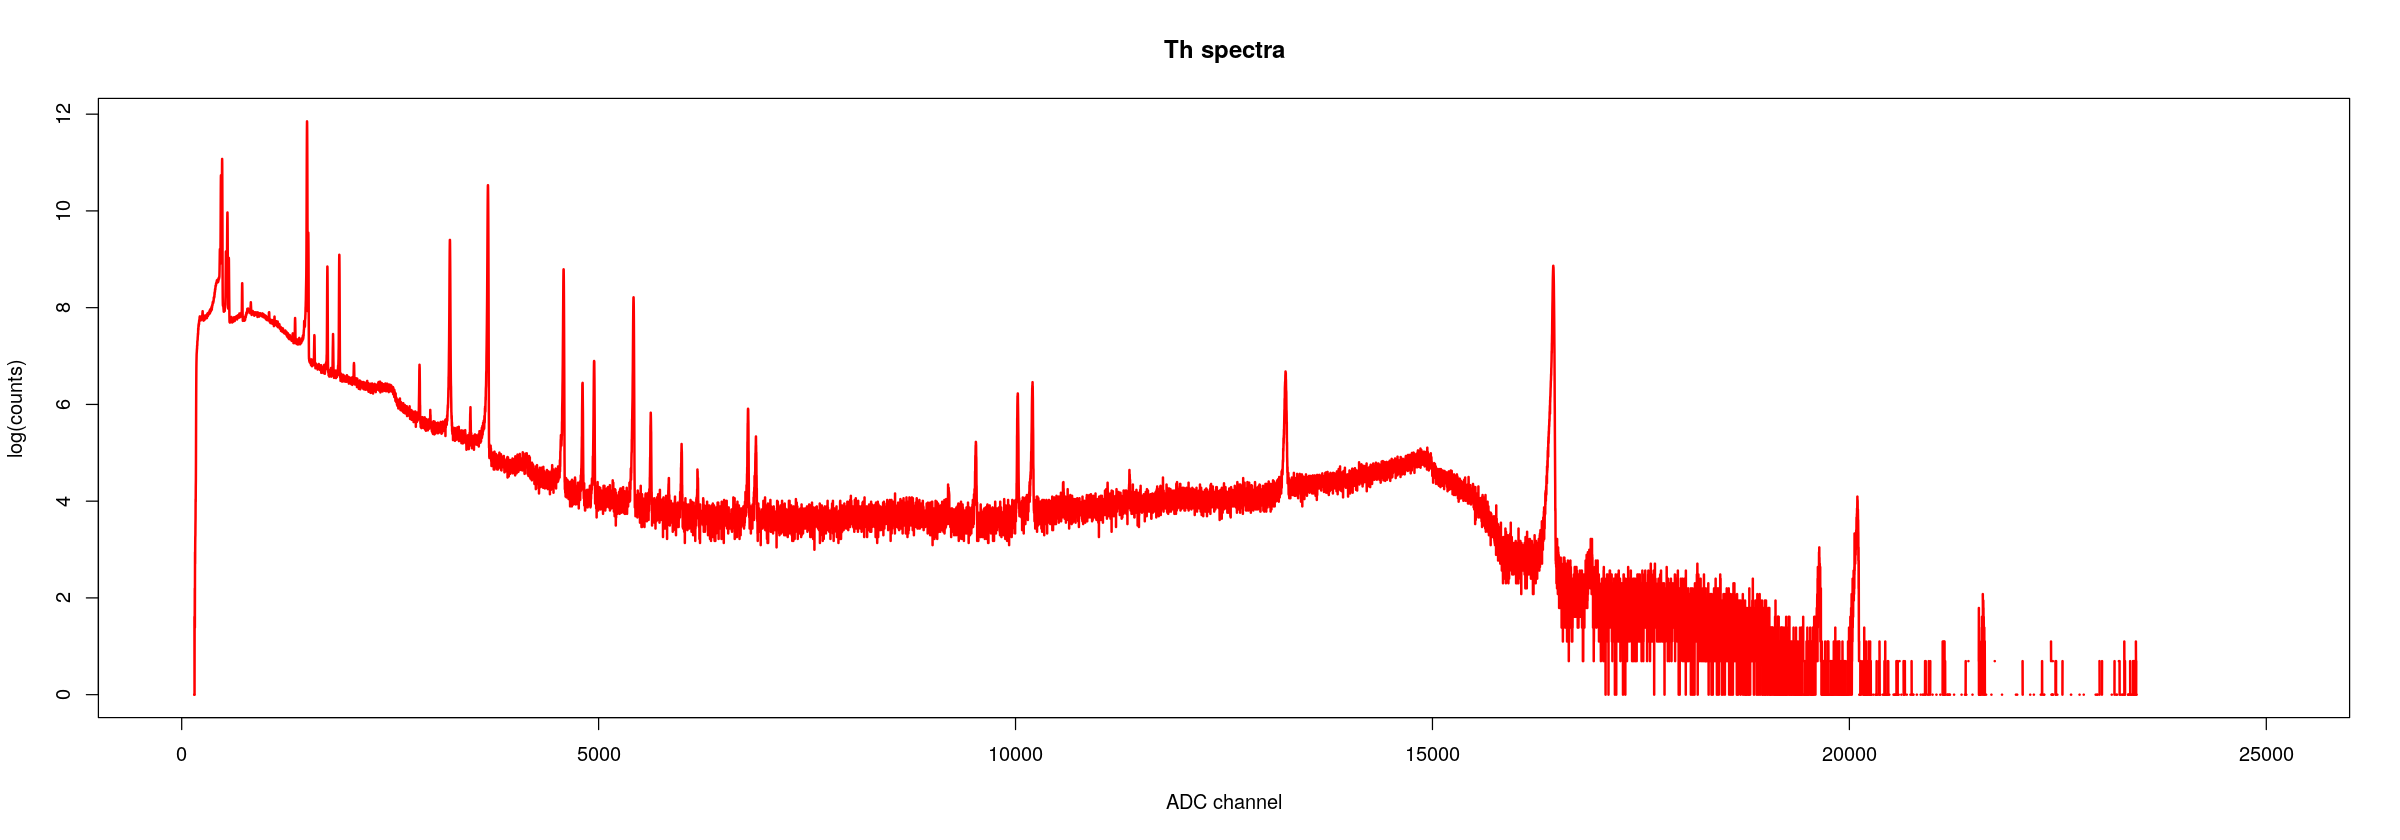

In [2]:
data <- read.delim(file = 'IC48A_Th.txt')
colnames(data) <- c("adc", "counts")
adc <- data$adc
counts <- data$counts
options(repr.plot.width = 20, repr.plot.height = 7) 

plot(adc,log(counts),'l',lwd=2,col="red", 
     xlab="ADC channel", ylab="log(counts)", main="Th spectra")


##  Inference of the centroids of each $\gamma$ peaks for all available sources  <a name="p1"></a>
Infering the ADC peaks from JAGS to then calibrate the detector

In [3]:
peaks_low <- c(1490,1875,3195,3650,4560,4790,4920,5390,5600,6760,9480,10000,10170,13180,16380)
peaks_high <- c(1515,1905,3235,3690,4600,4830,4970,5450,5650,6810,9570,10050,10230,13280,16500)
offset <- c(1,1000,1,1,1,50,100,1,30,30,30,50,50,100,1)
amplitude <- c(130000, 7500, 12000, 36000, 6500, 550, 850, 3500, 300, 330,140, 400, 550, 650, 6500)
peaks <- c(1503,1890,3216, 3672, 4580, 4806,4945, 5418, 5625, 6792,9525, 10025,10203, 13238, 16450)


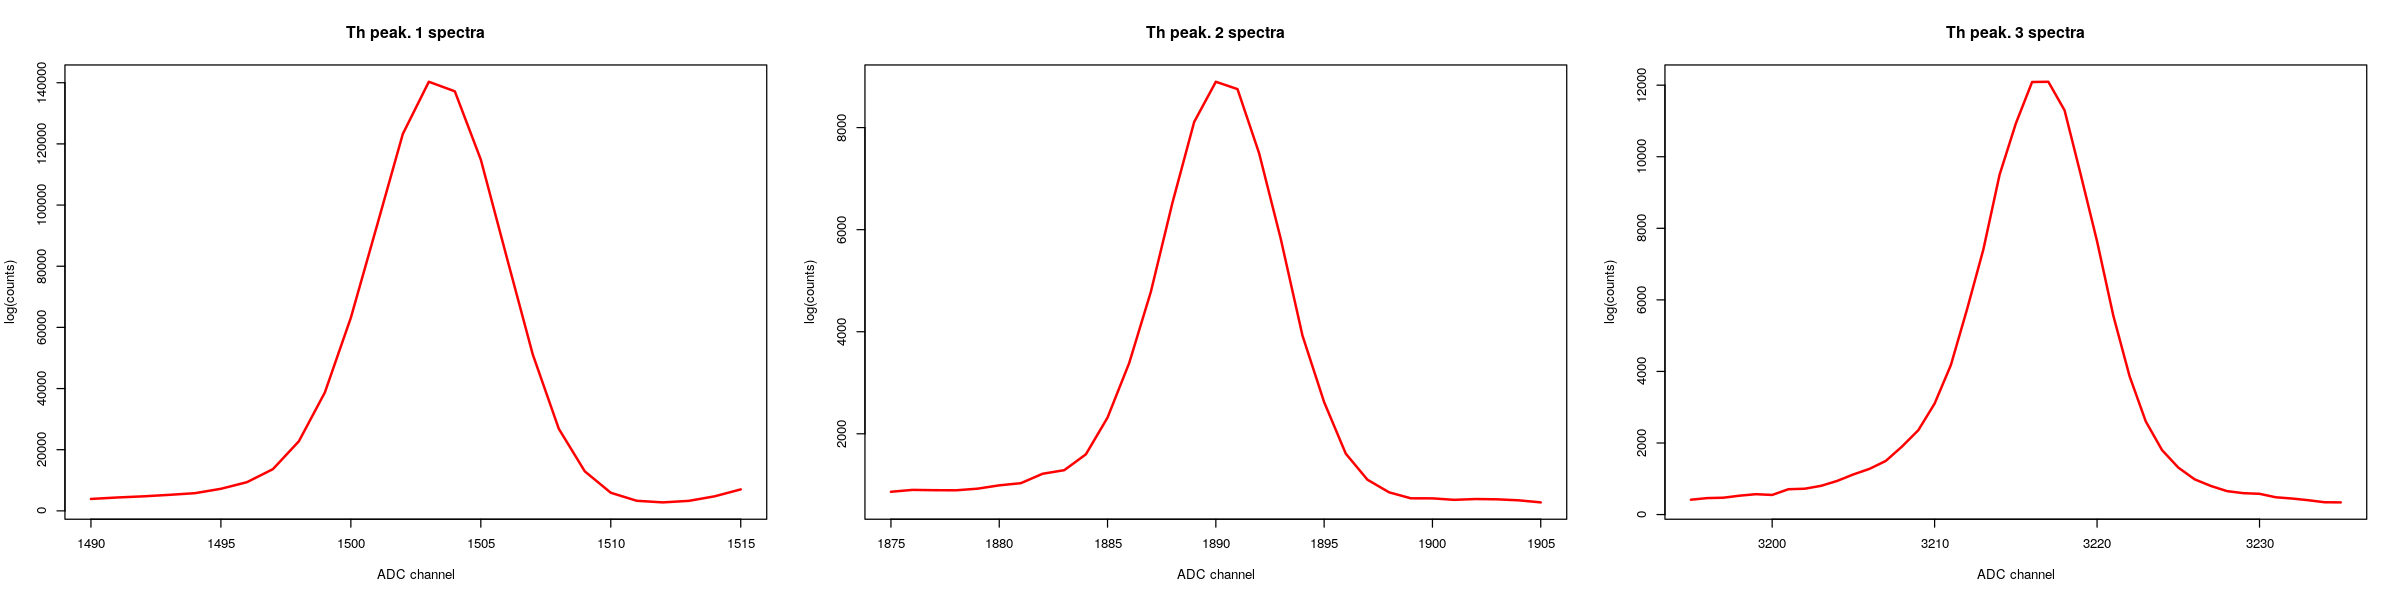

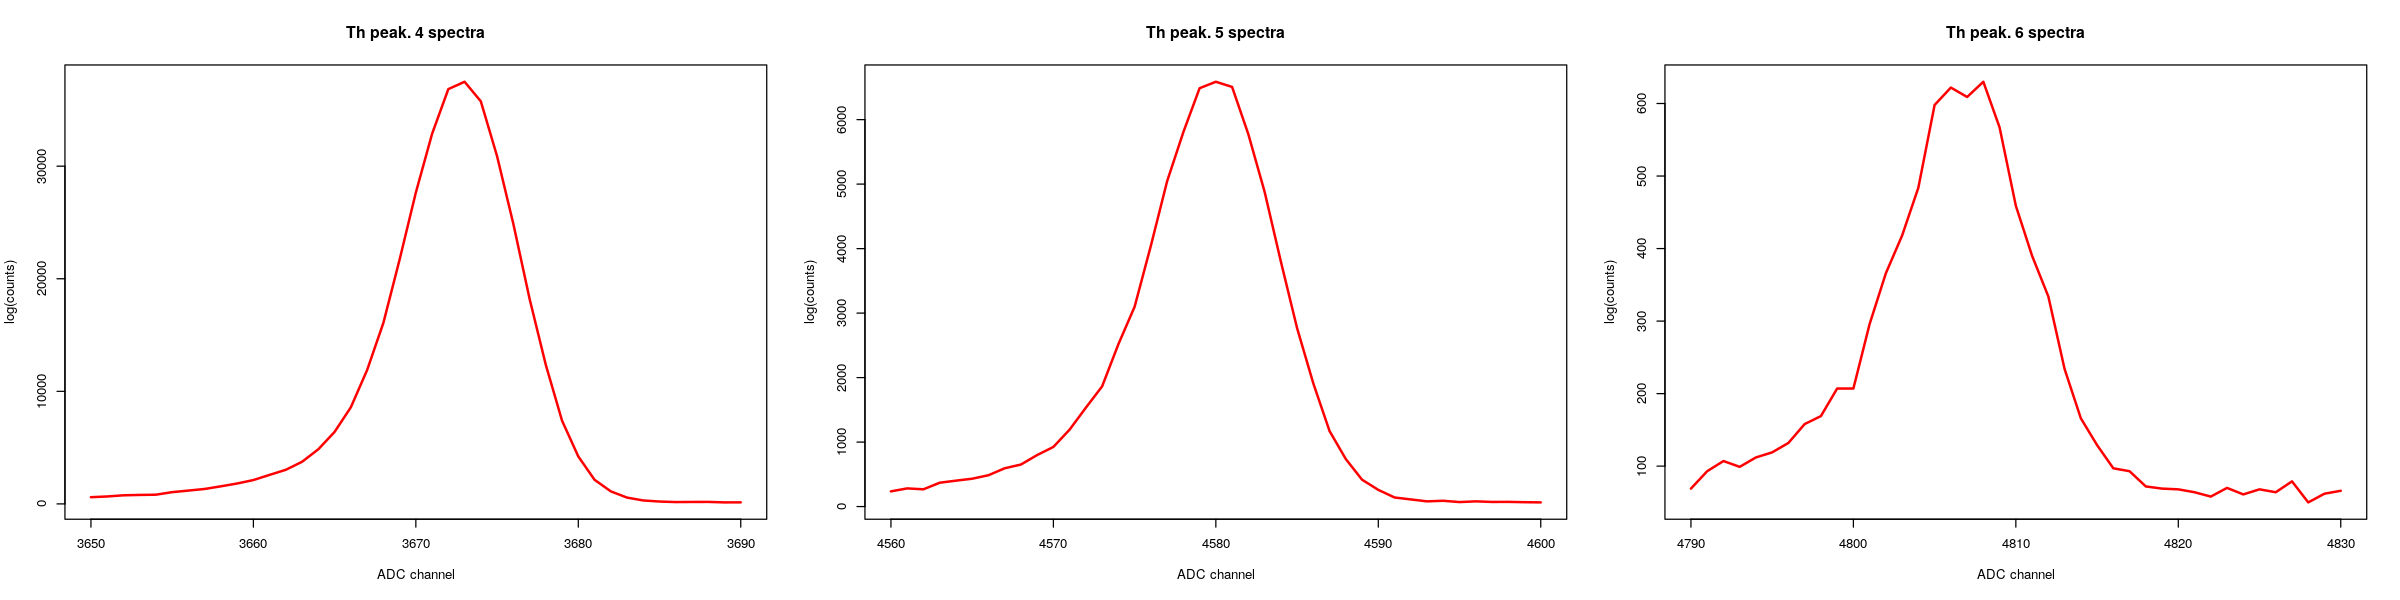

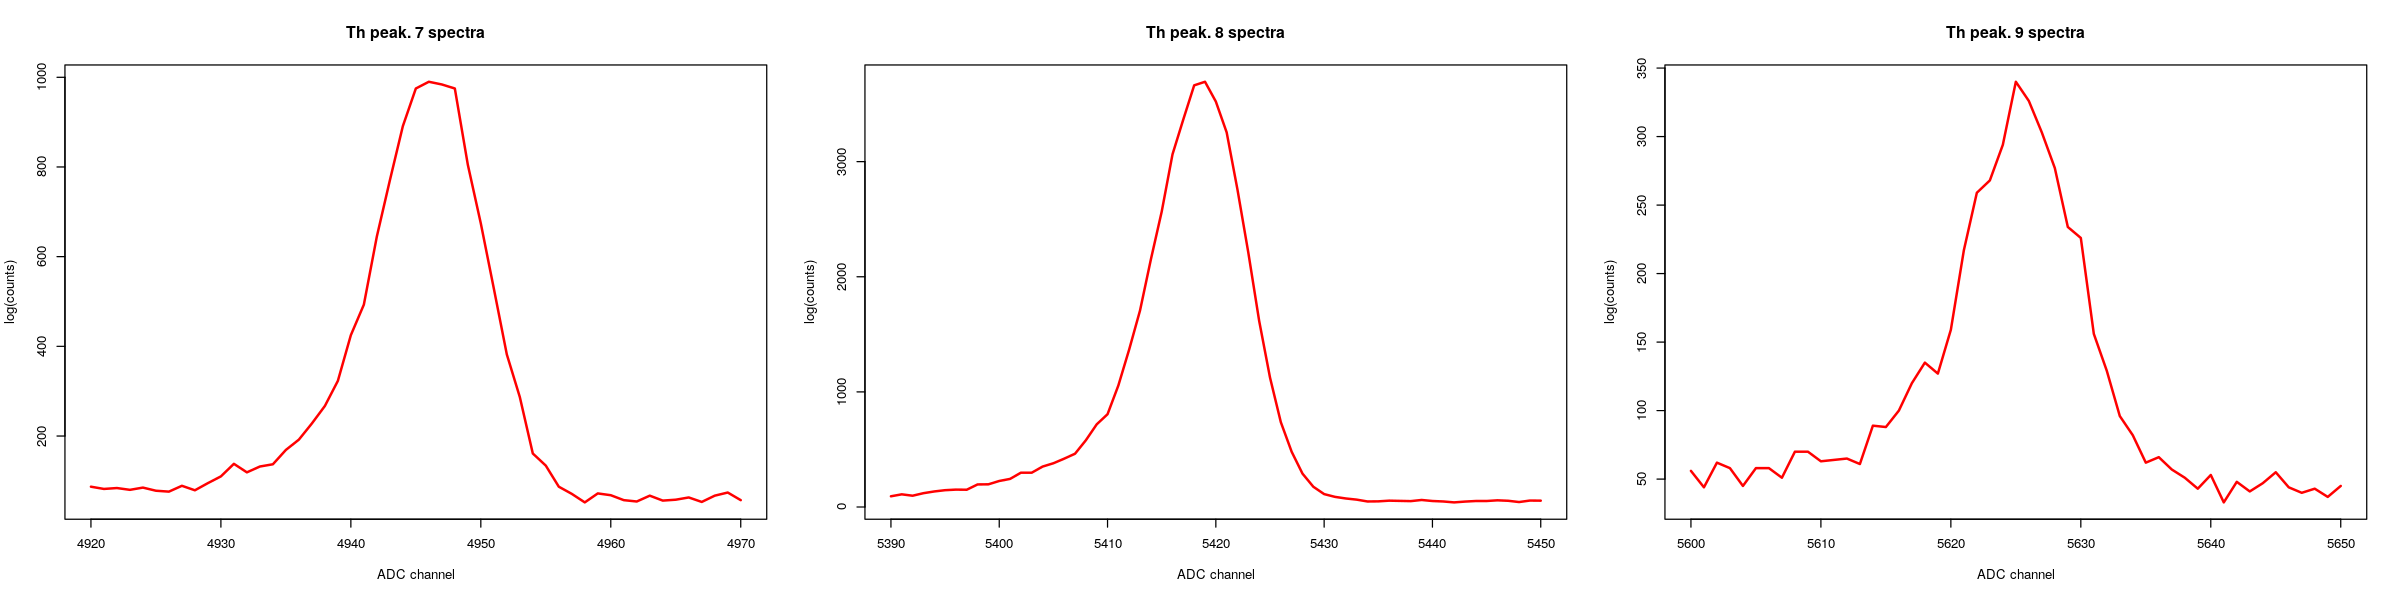

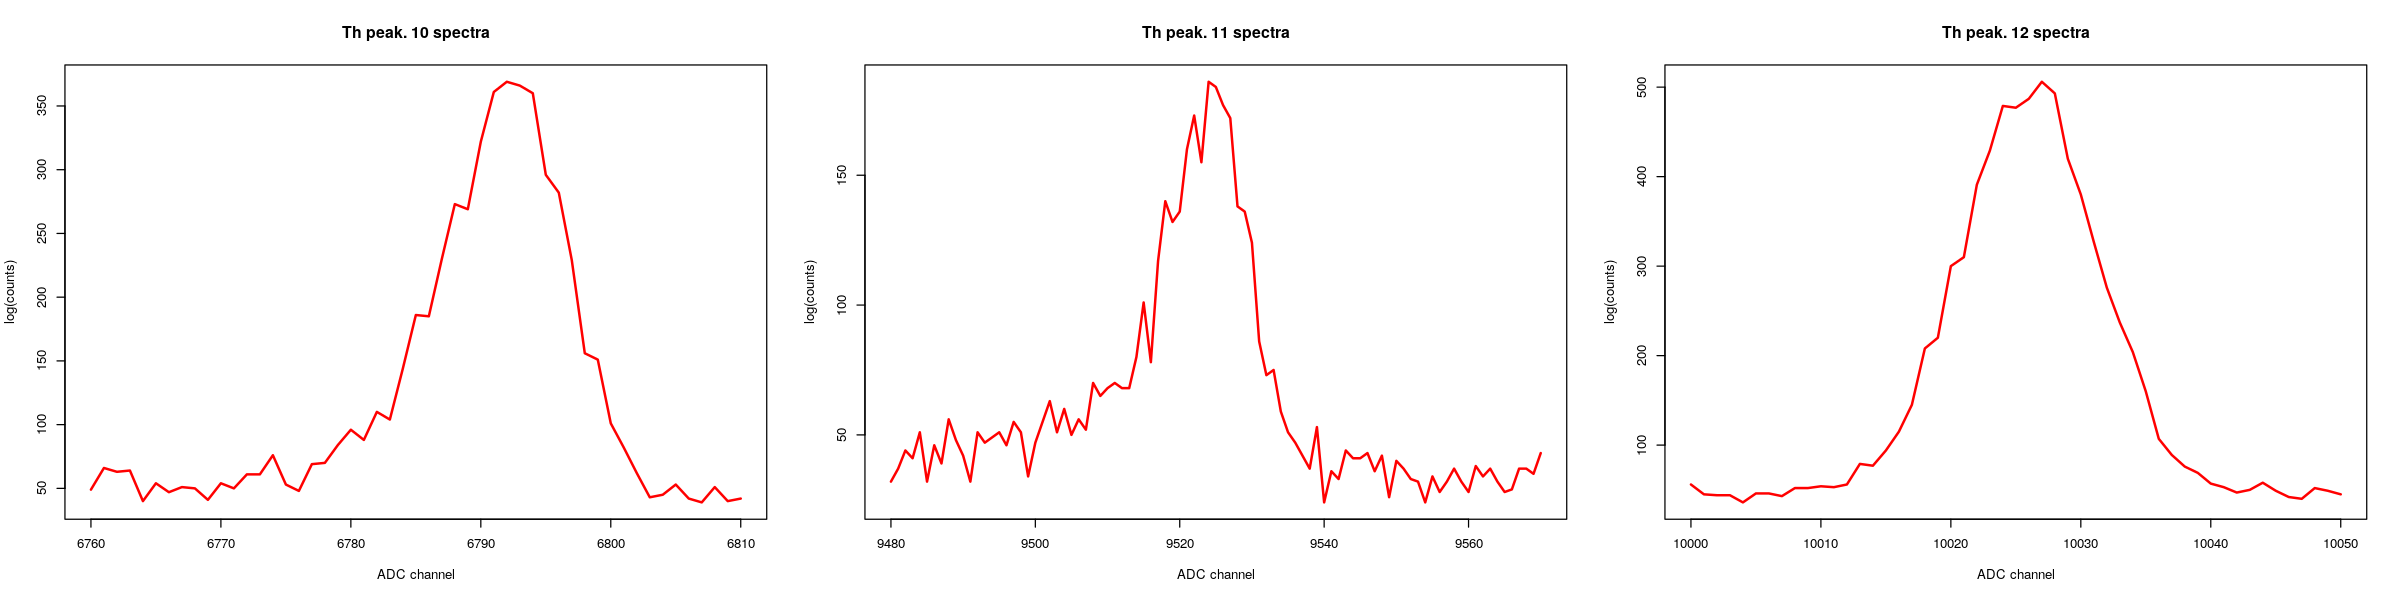

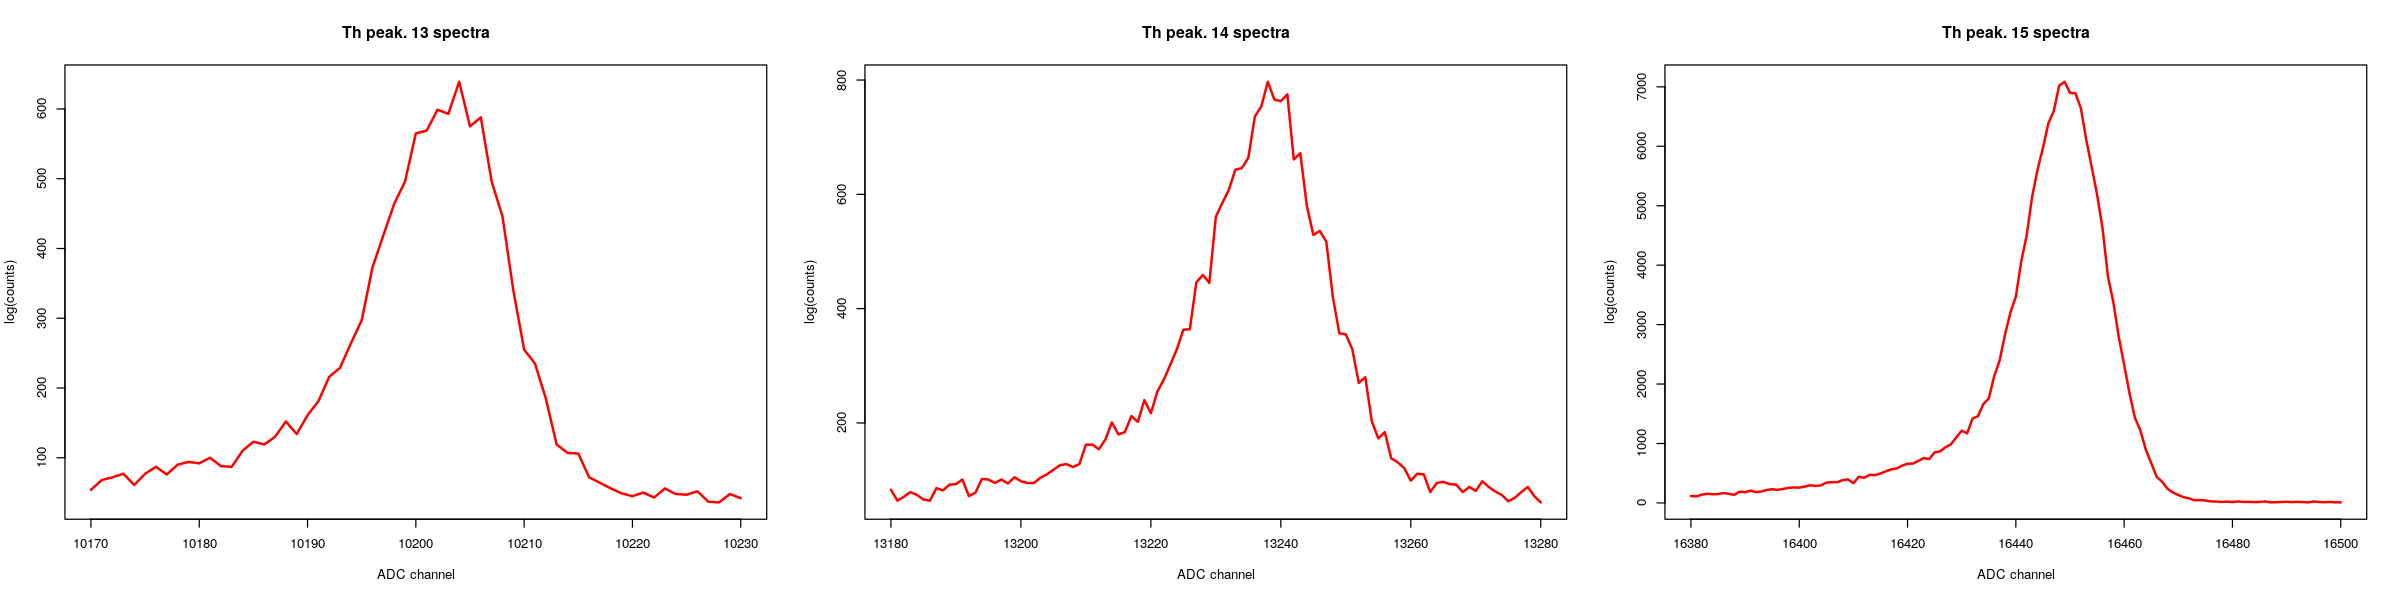

In [4]:
options(repr.plot.width = 20, repr.plot.height = 5) 
par(mfrow=c(1, 3))

for (i in 1:15){
    plot(peaks_low[i]:peaks_high[i],counts[peaks_low[i]:peaks_high[i]],'l',lwd=2,col="red", 
    xlab="ADC channel", ylab="log(counts)", main=paste("Th peak.",i,"spectra"))
    }


In [5]:
cat(" 
model { 
    # data likelihood 
    for (i in 1:length(N)) { 
        N[i] ~ dpois(S[i]);
        S[i] <- B+A*exp(-((X[i]-mu)^2)/(2*sigma^2));  
    } 
    # prior
    mu ~ dunif(1000, 18000); 
    logsigma ~ dunif(-10,10); 
    sigma <- exp(logsigma)
    A ~ dunif(0,145000); 
    B ~ dunif(0,10000); 
 
} 
",file = 'projectth.bug') 

In [6]:
JAGS.fit <- function(data,inits,nit,thin,burnin,title){
    jm <- jags.model(file = 'projectth.bug', inits = inits, data=data,quiet=TRUE,n.adapt=burnin)
    chain <- coda.samples(jm, c("A", "B", "mu",'sigma'), n.iter=nit,thin=thin) 
    
    x <- data$X
    N <- data$N
    p <- summary(chain)$statistics[1:4] 
    val <- summary(chain)$statistics[,1]
    
    #options(repr.plot.width = 8, repr.plot.height = 6) 
    plot(x,N,lwd=2,col='blue',main="Th",xlab='ADC channel',ylab='N')
    xx <- seq(min(x),max(x),0.1)
    lines(xx,signal(xx,p[1],p[2],p[3],p[4]),lwd =2,col='red',lty=2)
    legend("topleft", legend=c("Peak from data", "Gaussian peak"),
       col=c("blue", "red"), lty=1:2, cex=1, pch= c(1, NULL),  bty="n")
    
    return(chain)
}



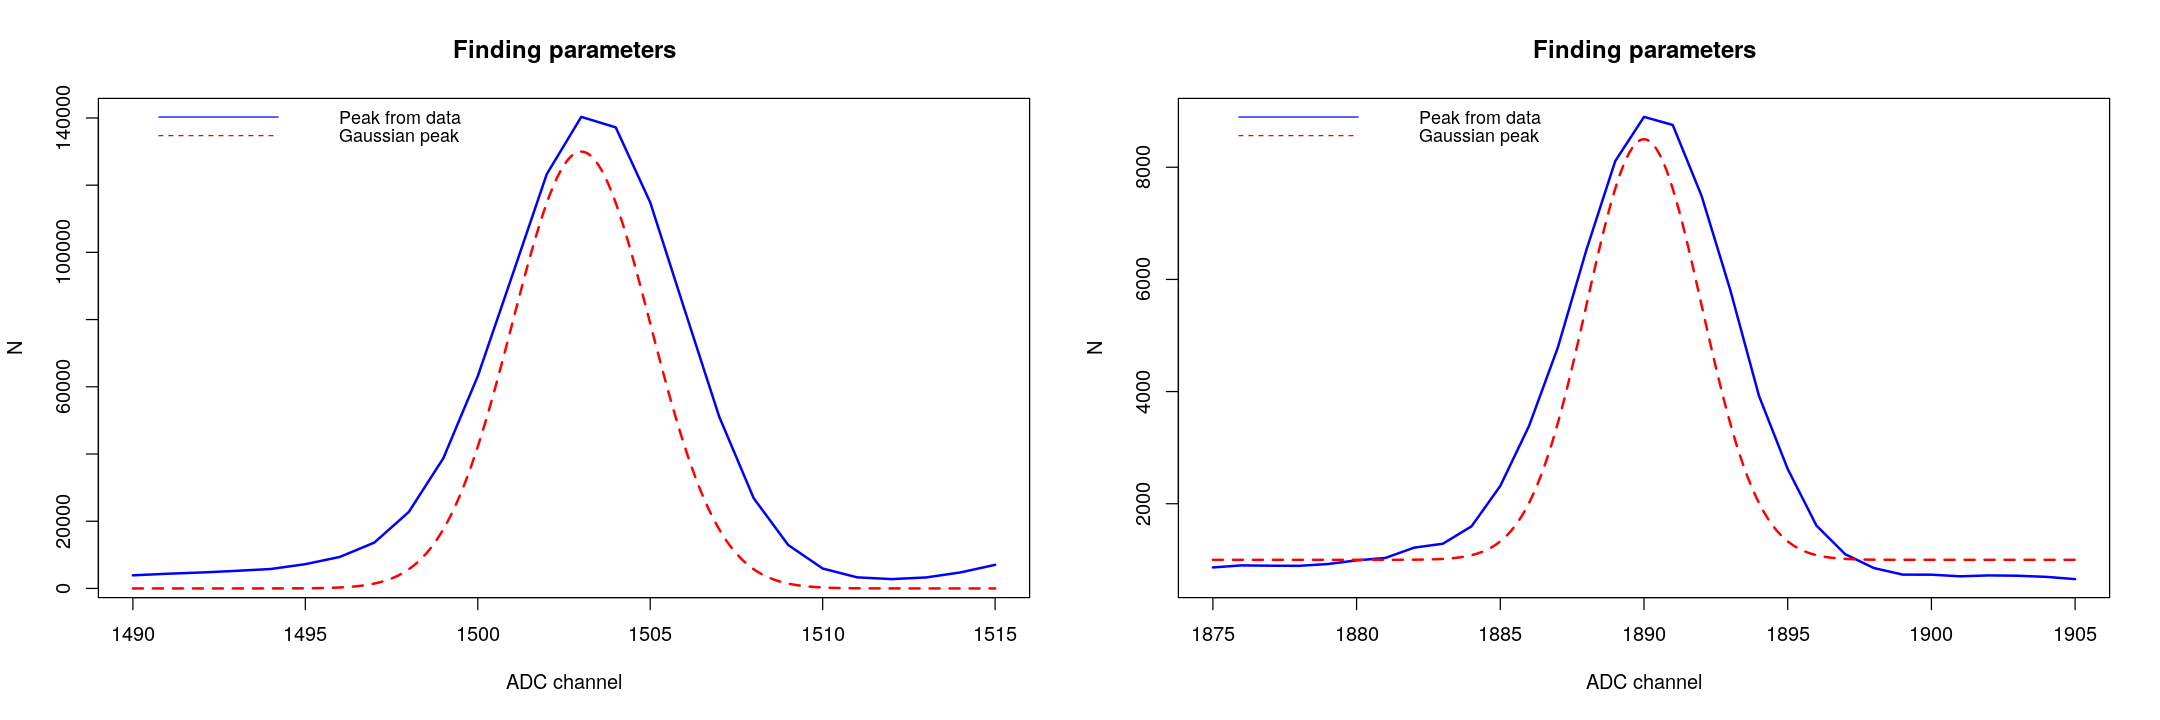

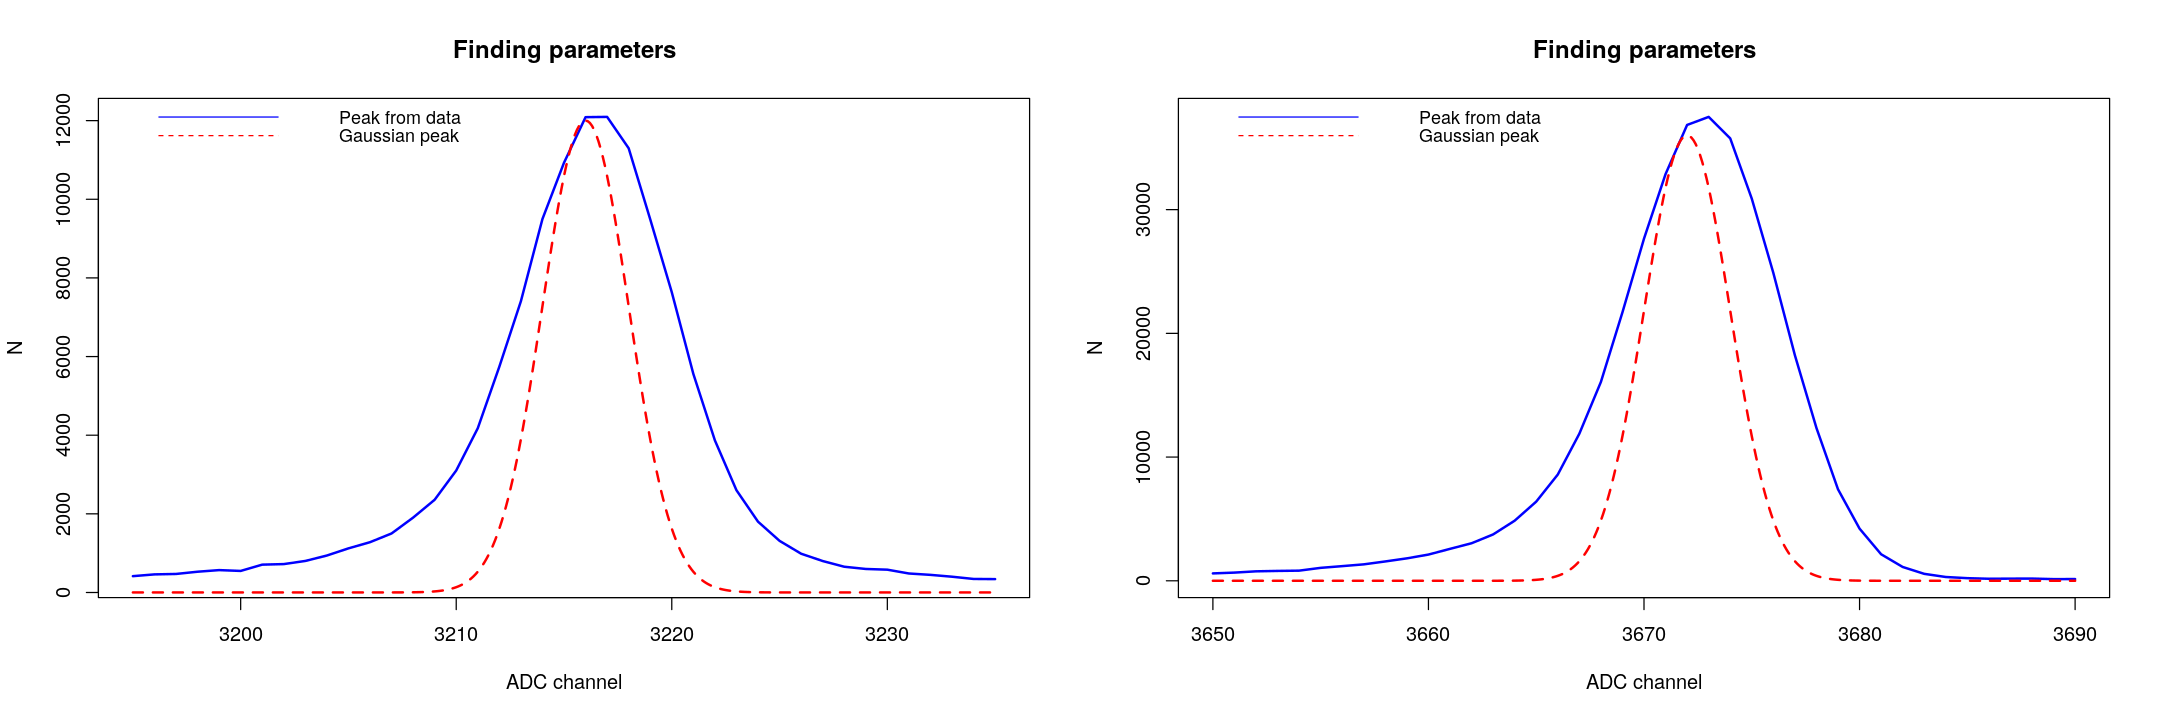

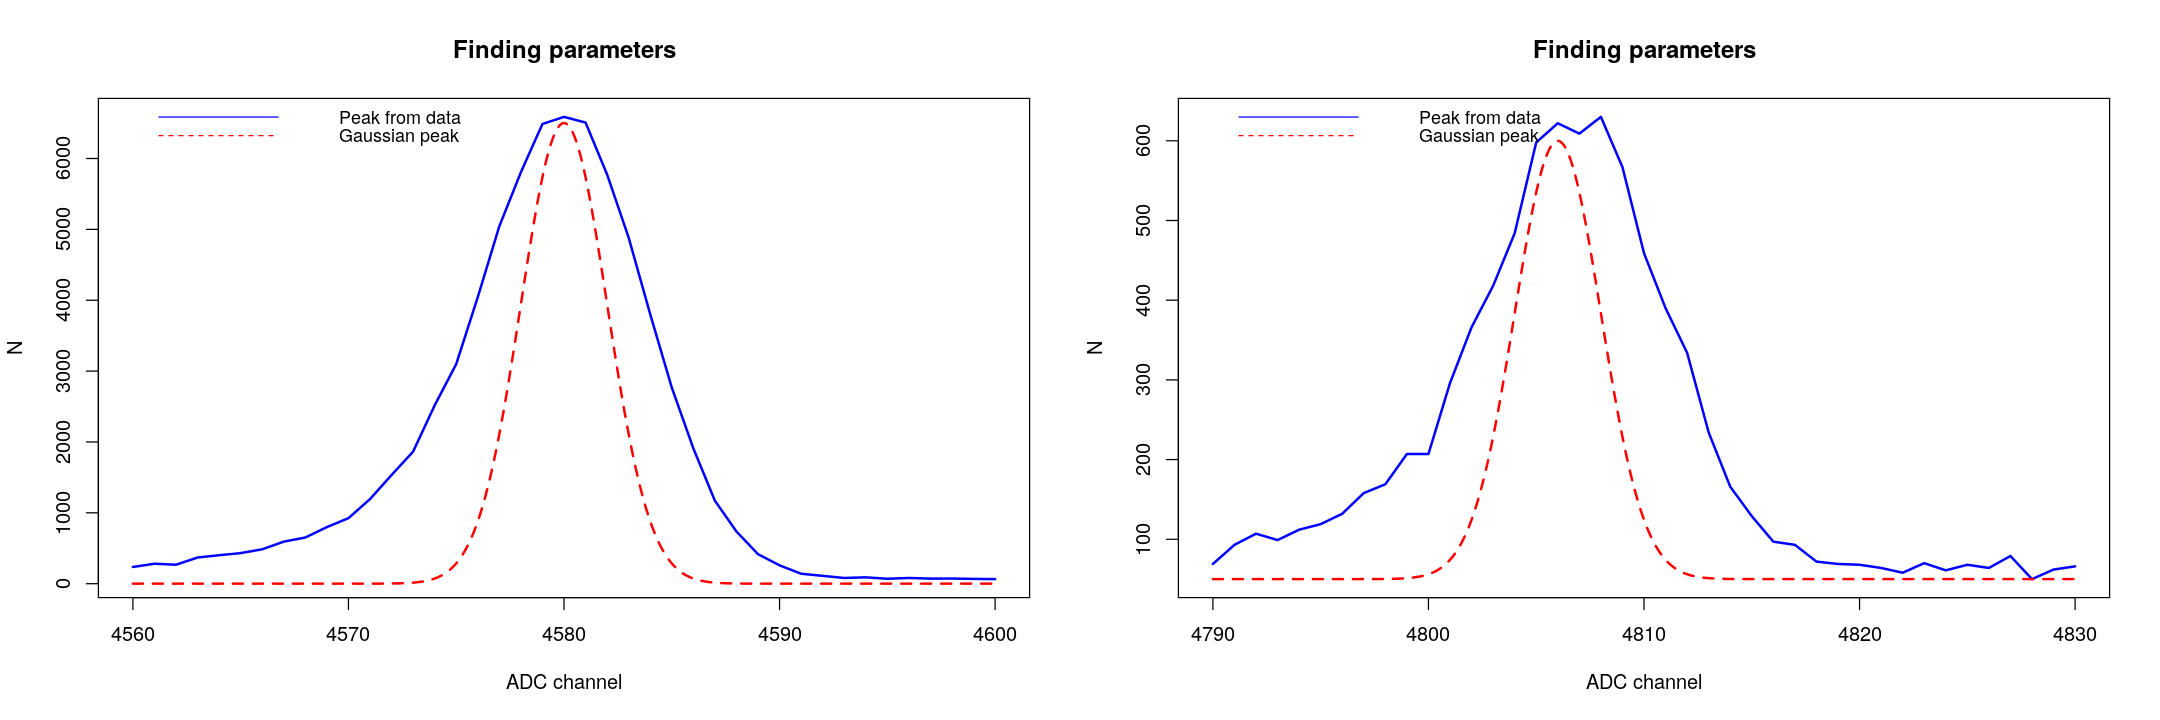

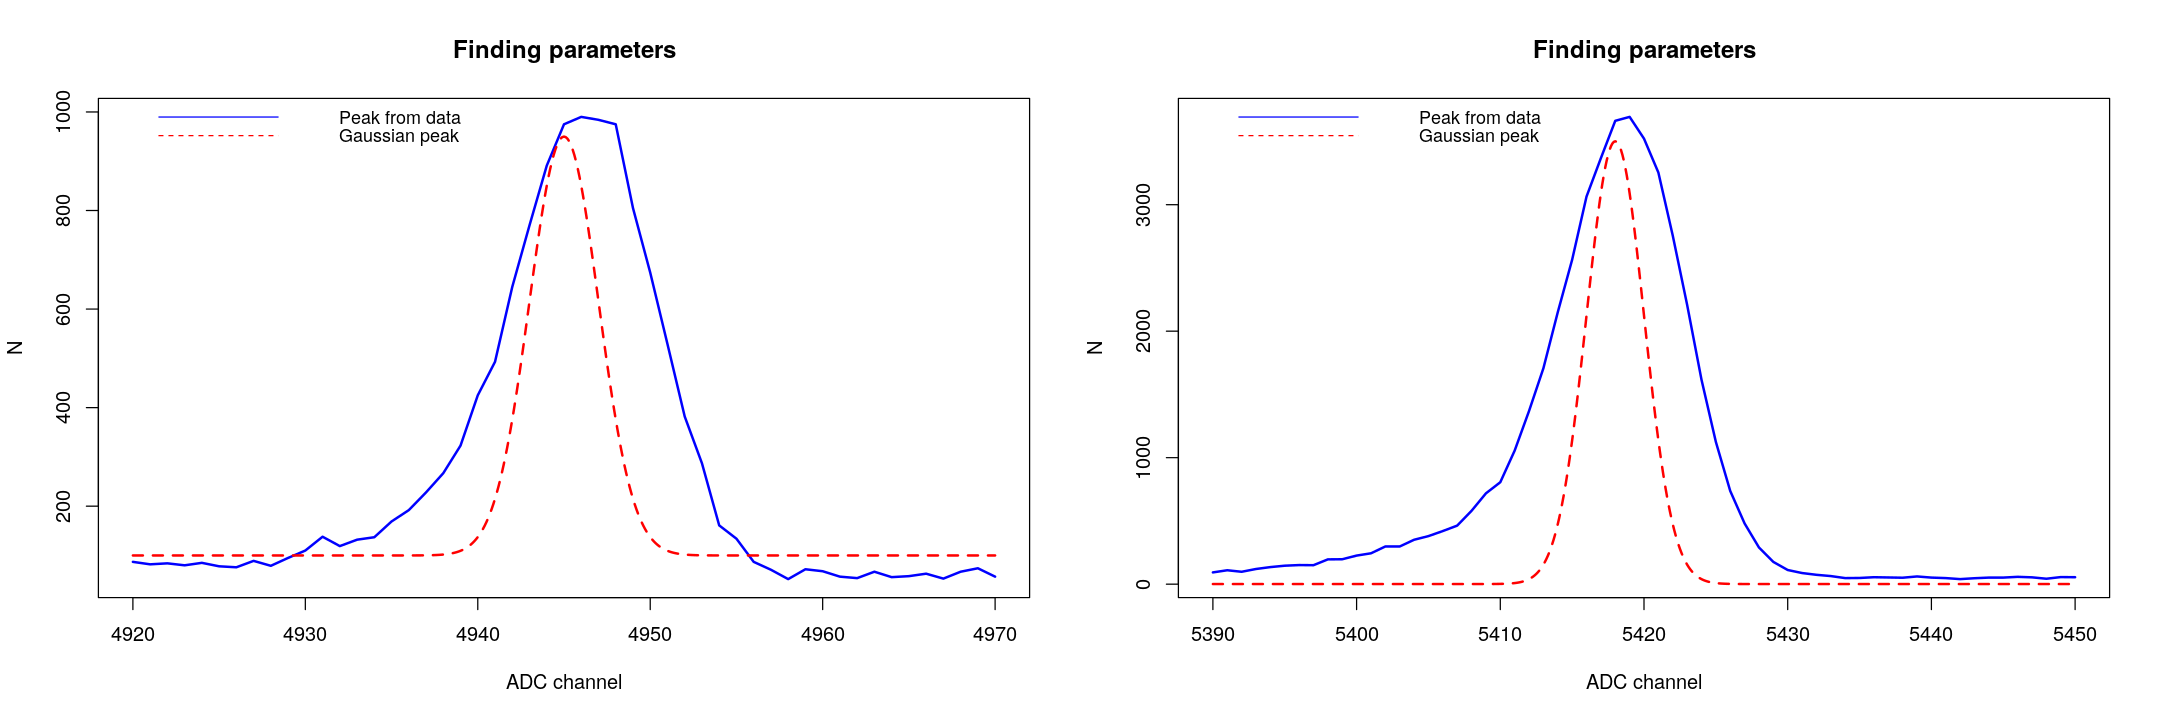

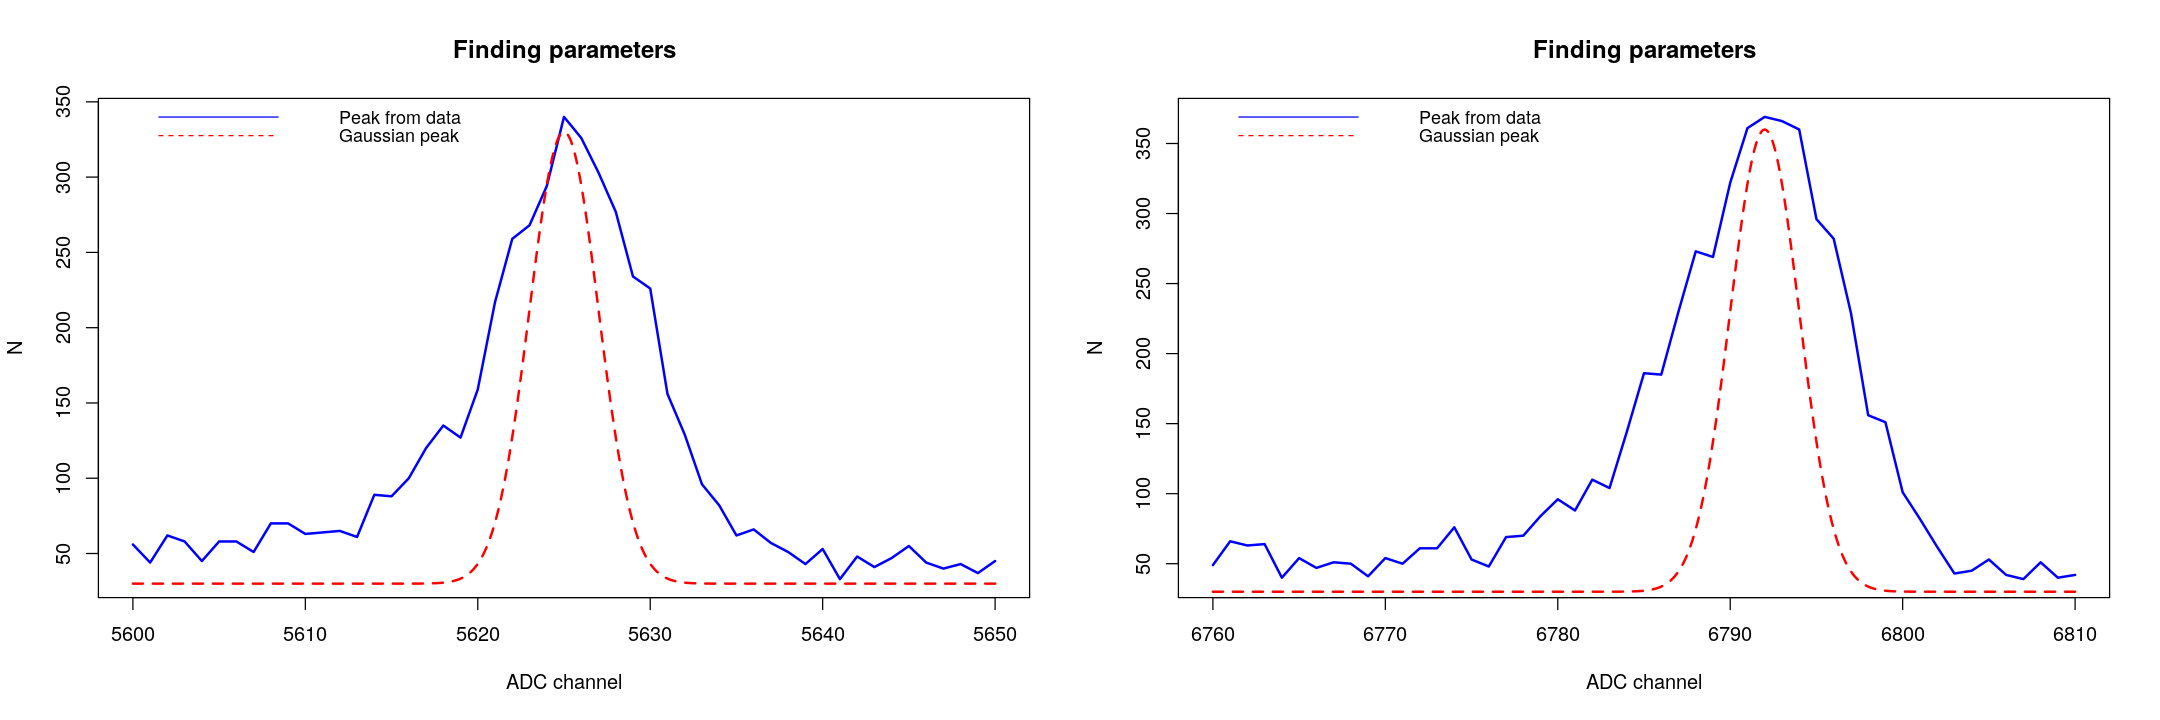

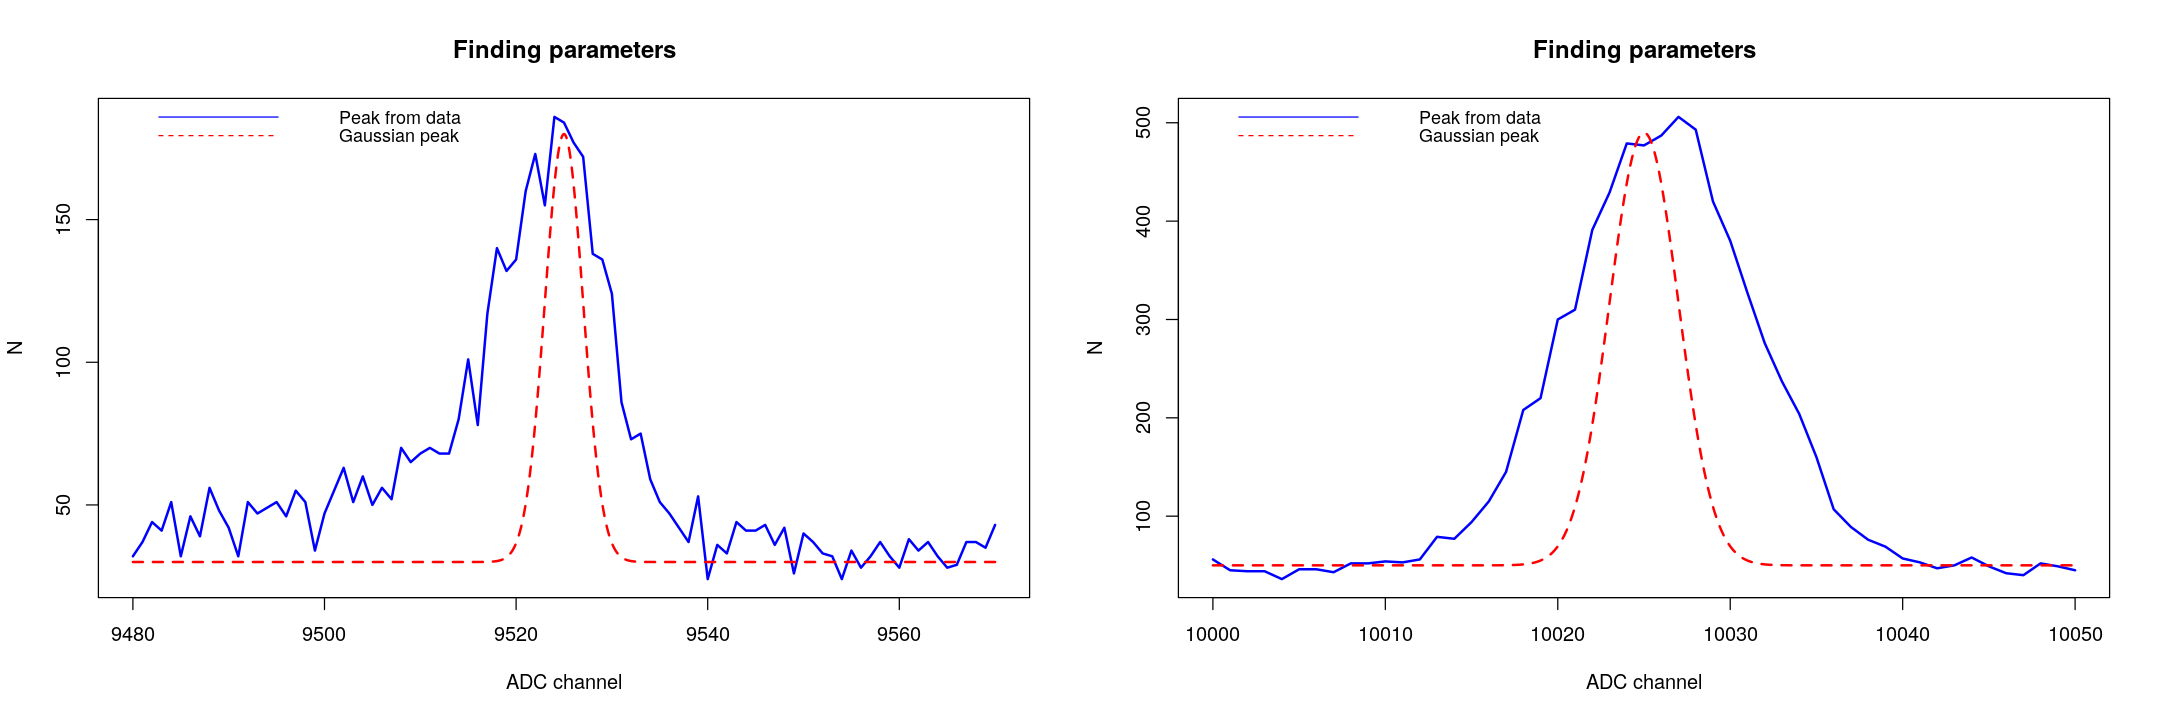

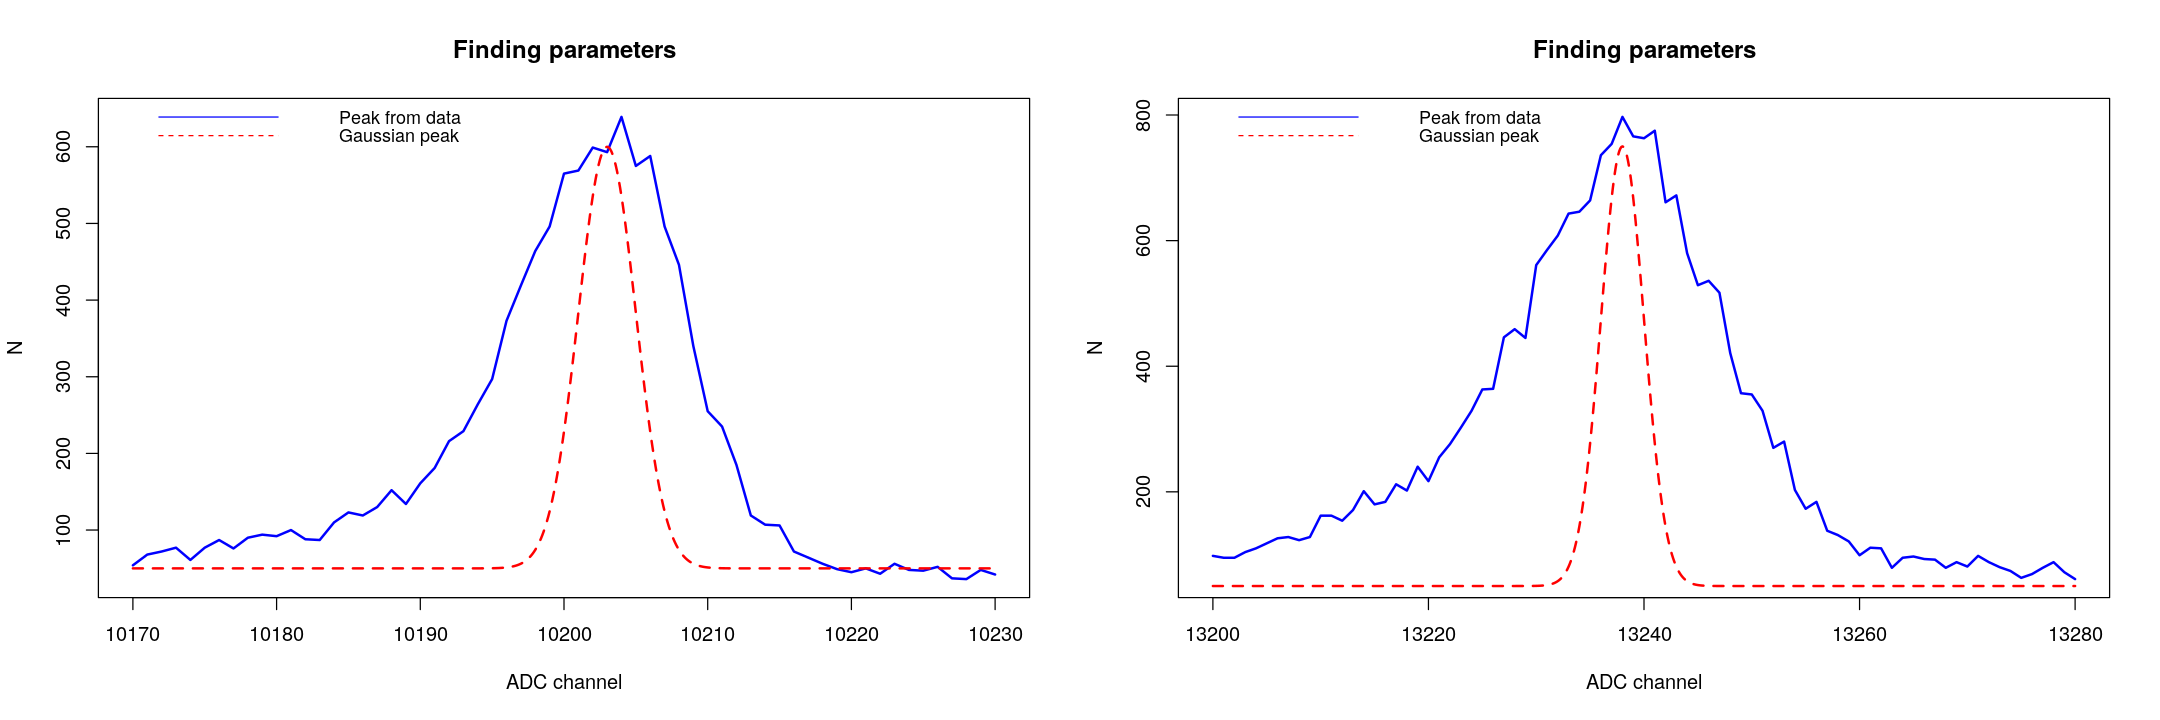

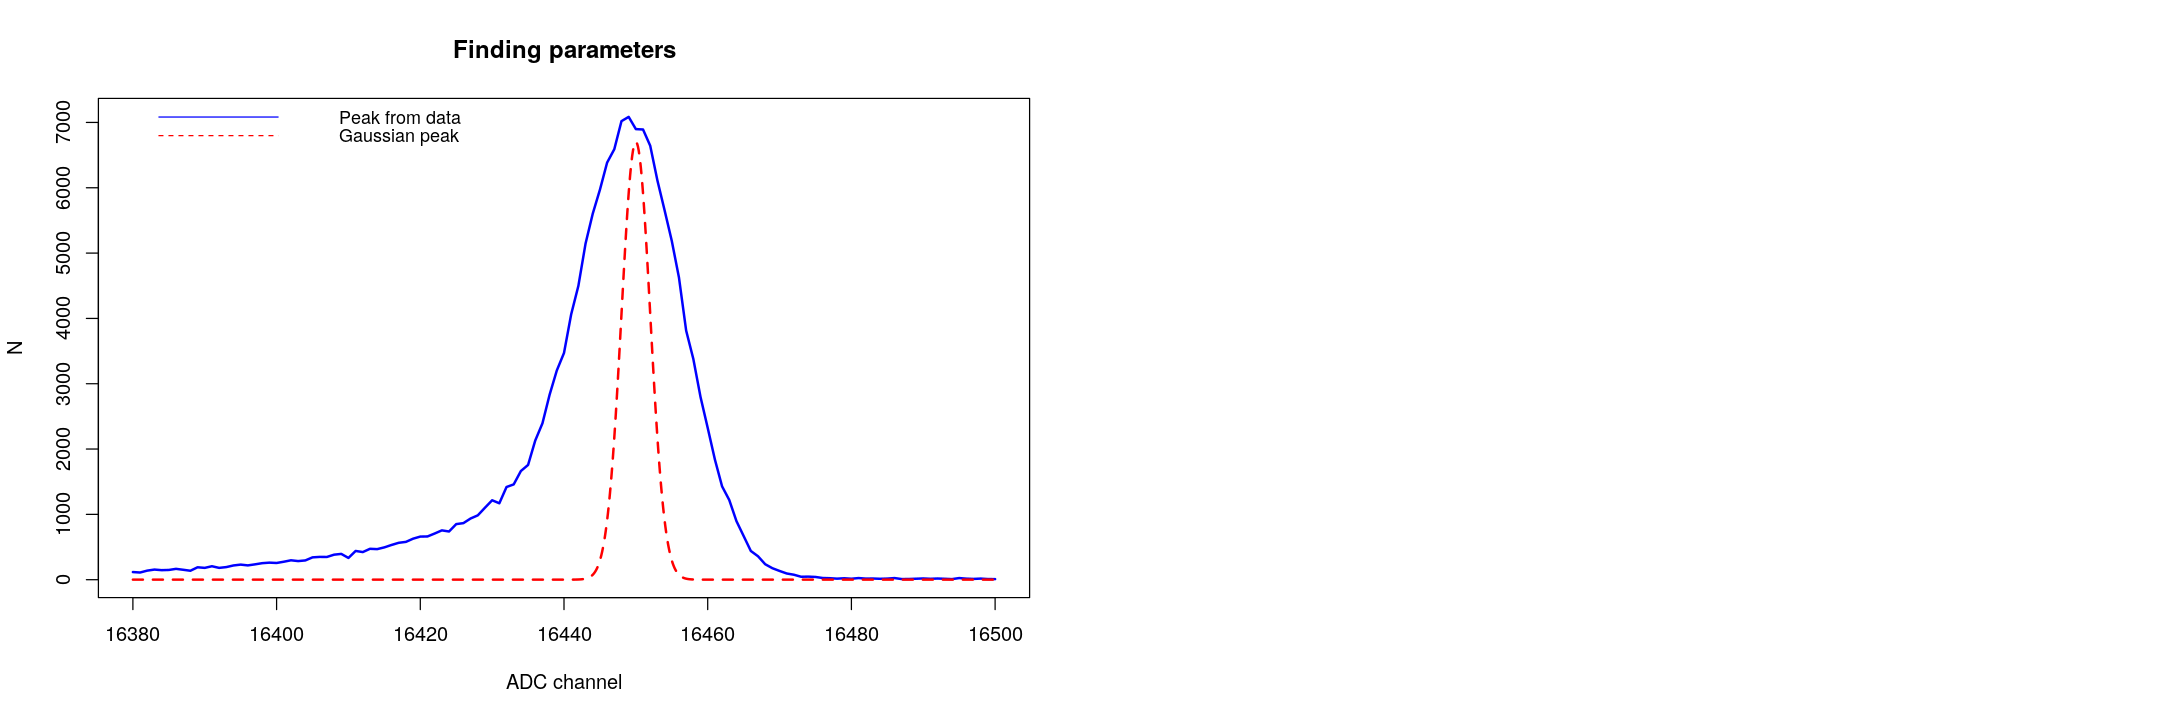

In [7]:
signal <- function(x,A,B,mu,sigma){
        B+A*exp(-((x-mu)^2)/(2*sigma^2))
    }

peaks_low <- c(1490,1875,3195,3650,4560,4790,4920,5390,5600,6760,9480,10000,10170,13200,16380)
peaks_high <- c(1515,1905,3235,3690,4600,4830,4970,5450,5650,6810,9570,10050,10230,13280,16500)
offset <- c(1,1000,1,1,1,50,100,1,30,30,30,50,50,50,1)
amplitude <- c(130000, 7500, 12000, 36000, 6500, 550, 850, 3500, 300, 330,150, 440, 550, 700, 6700)
peaks <- c(1503,1890,3216, 3672, 4580, 4806,4945, 5418, 5625, 6792,9525, 10025,10203, 13238, 16450)

par(mfrow=c(1,2))

for (i in 1:length(peaks)){
    inf <- peaks_low[i]
    sup <- peaks_high[i]
    
    x <- adc[inf:sup]
    N <- counts[inf:sup]


    p <- c(amplitude[i],offset[i],peaks[i],2)
    
    
    options(repr.plot.width = 18, repr.plot.height = 6) 
    plot(x,N,'l',lwd=2,col='blue',xlab='ADC channel',ylab='N',main='Finding parameters')
    xx <- seq(min(x),max(x),0.1)
    lines(xx,signal(xx,p[1],p[2],p[3],p[4]),lwd =2,col='red',lty=2)
    legend("topleft", legend=c("Peak from data", "Gaussian peak"),
       col=c("blue", "red"), lty=1:2,cex=0.9, bty="n")
}


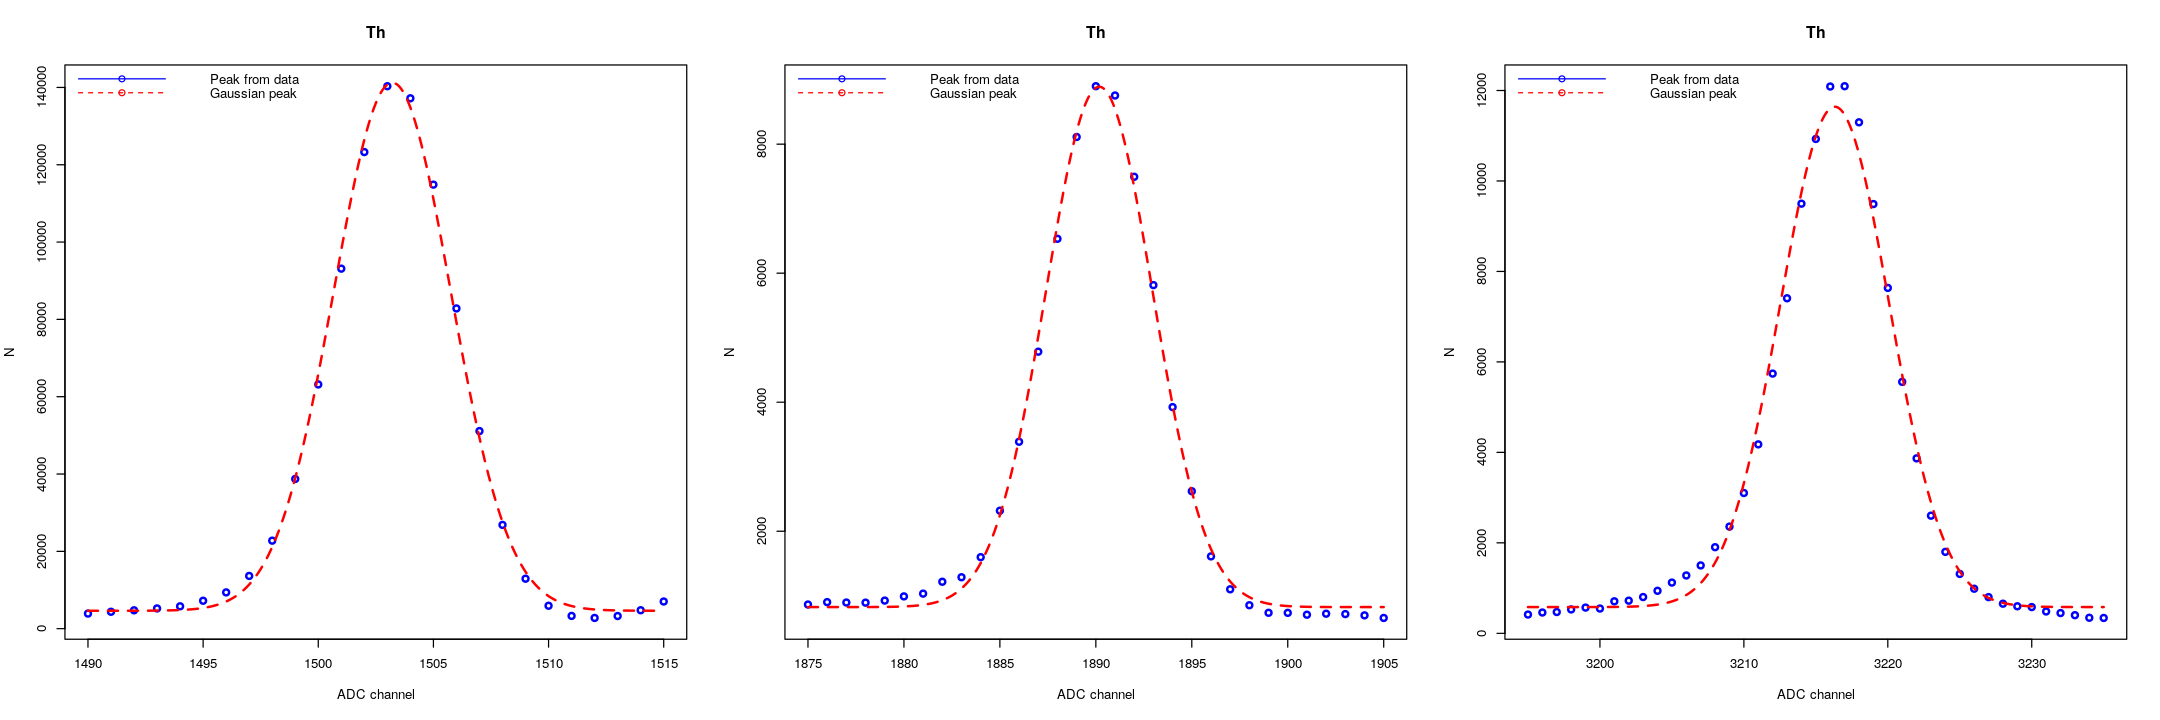

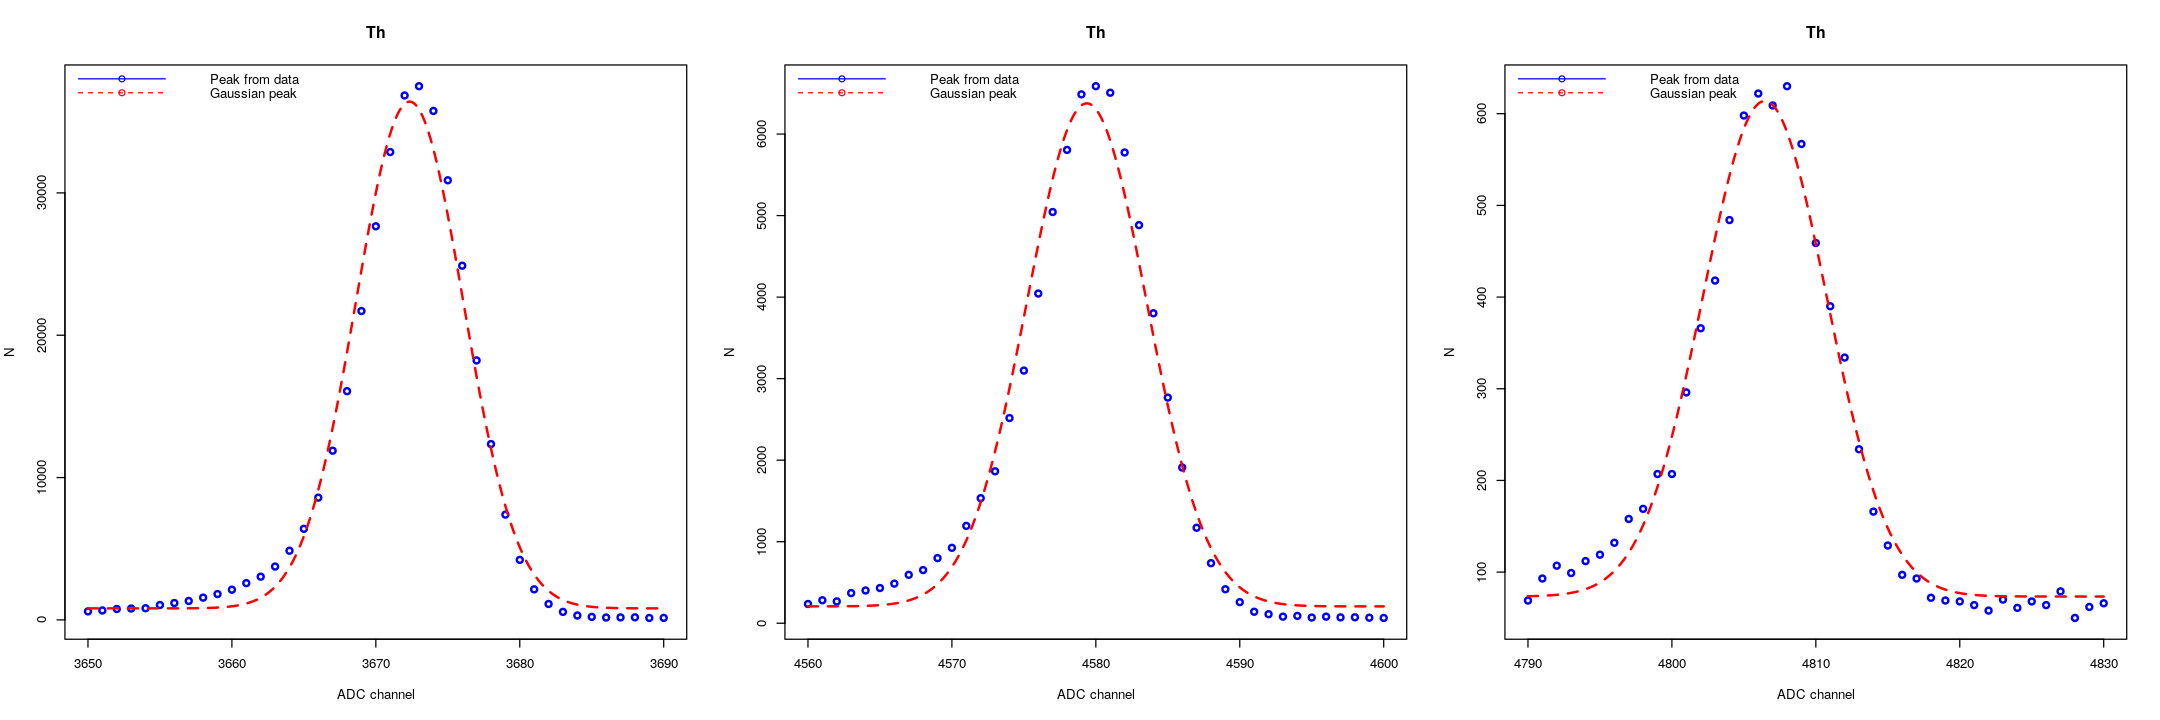

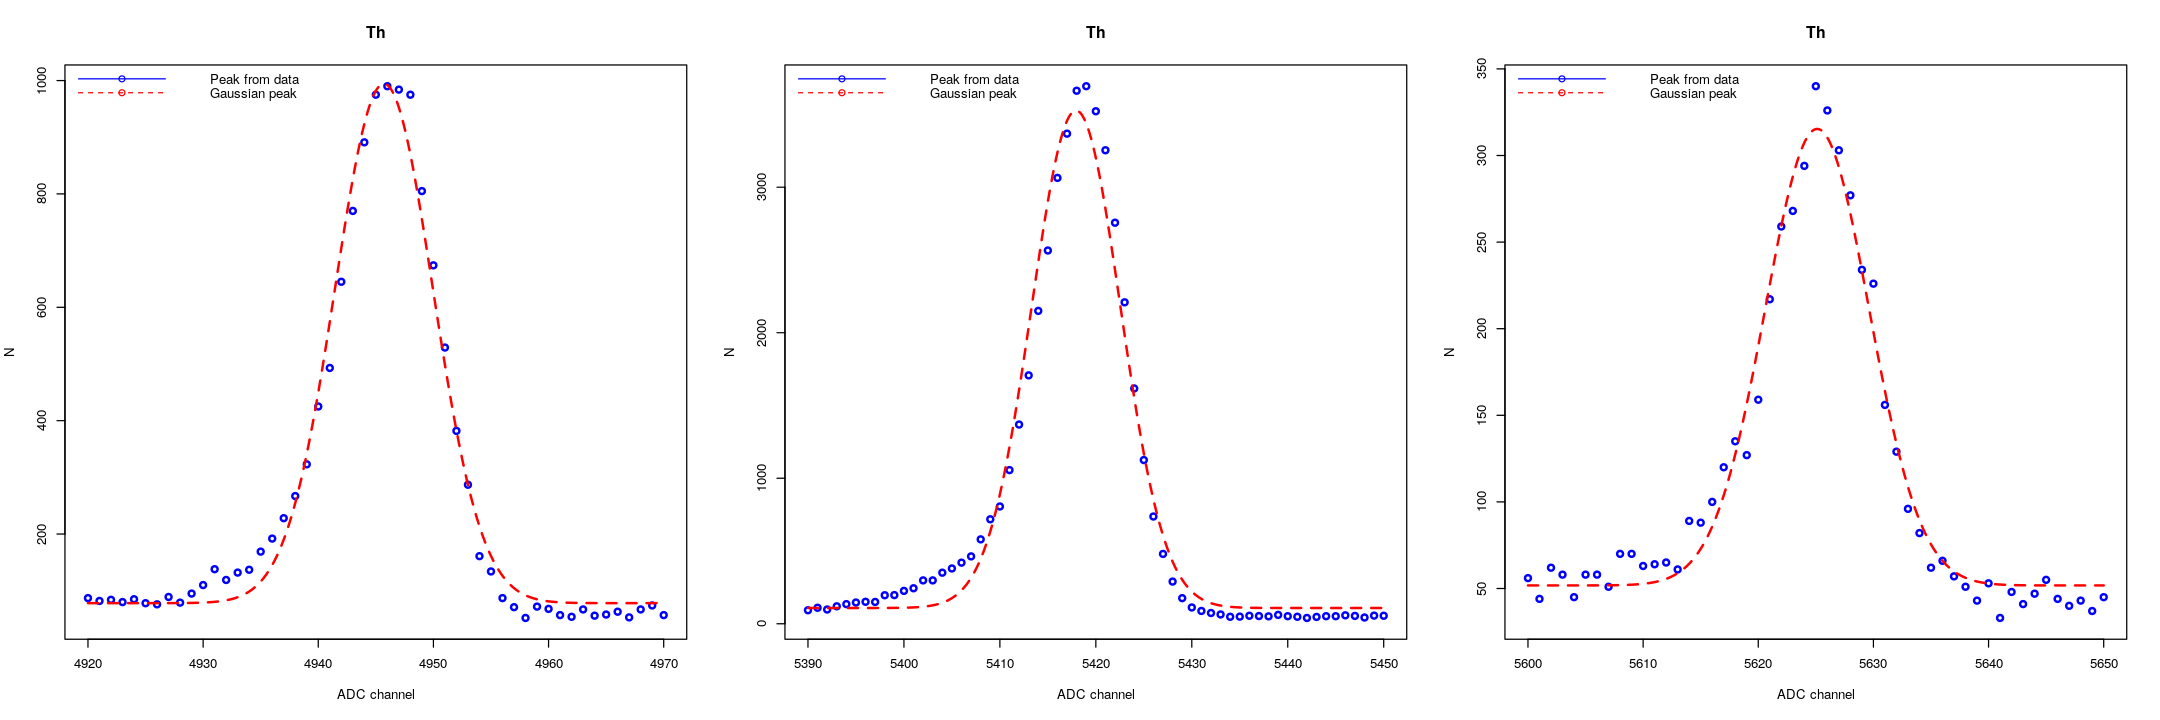

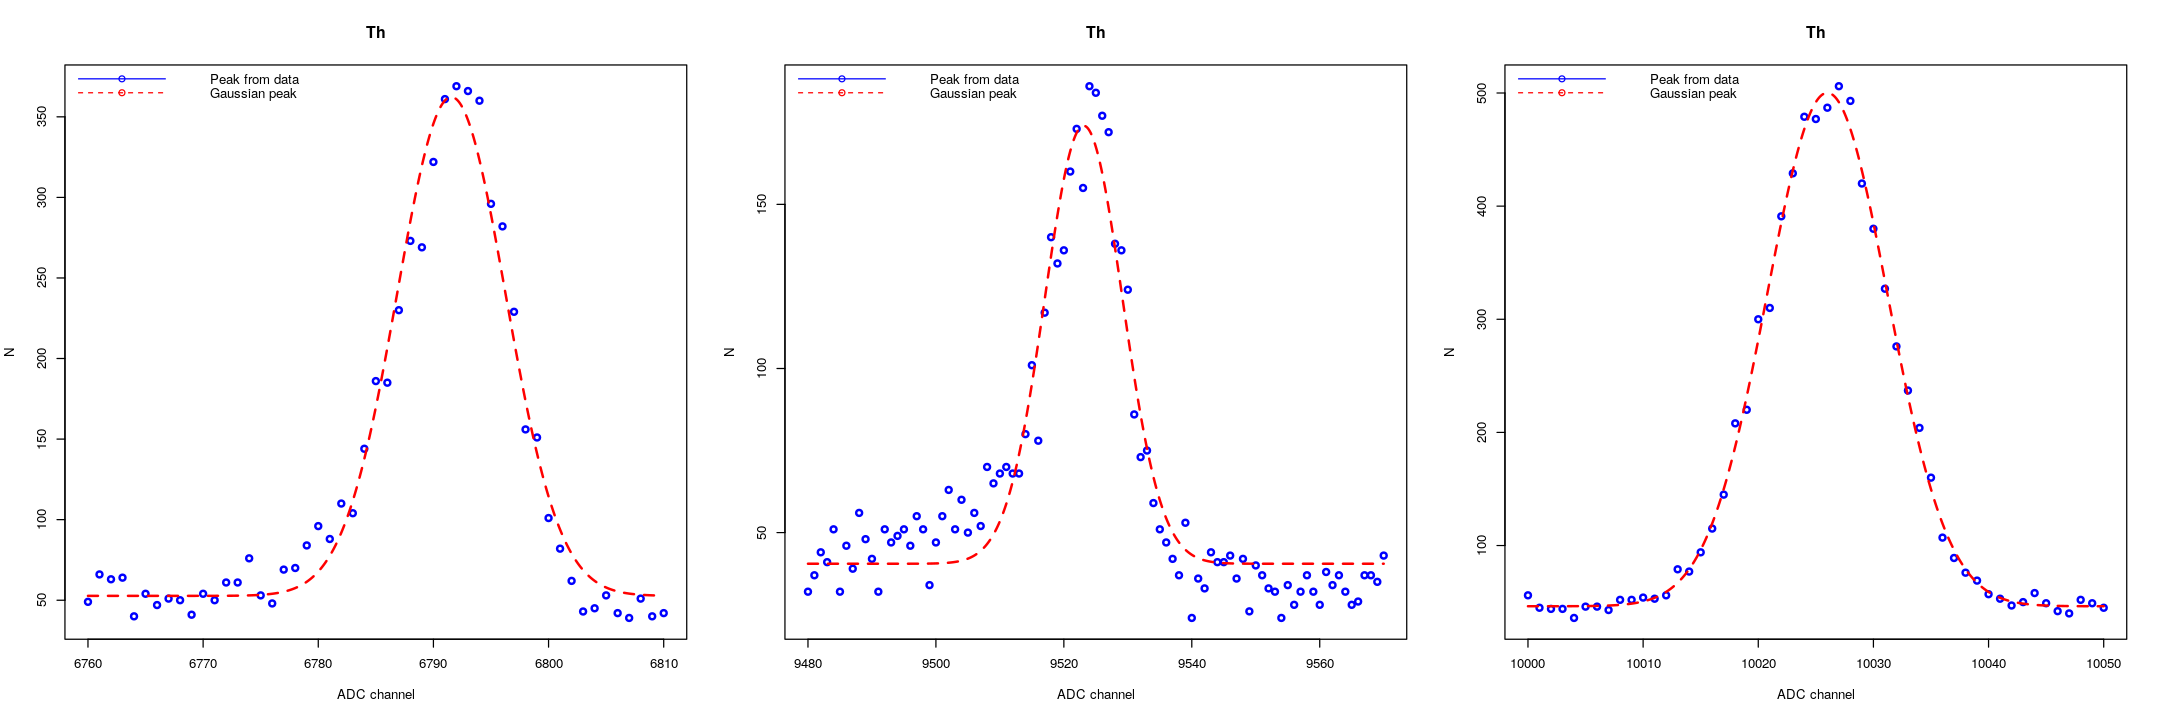

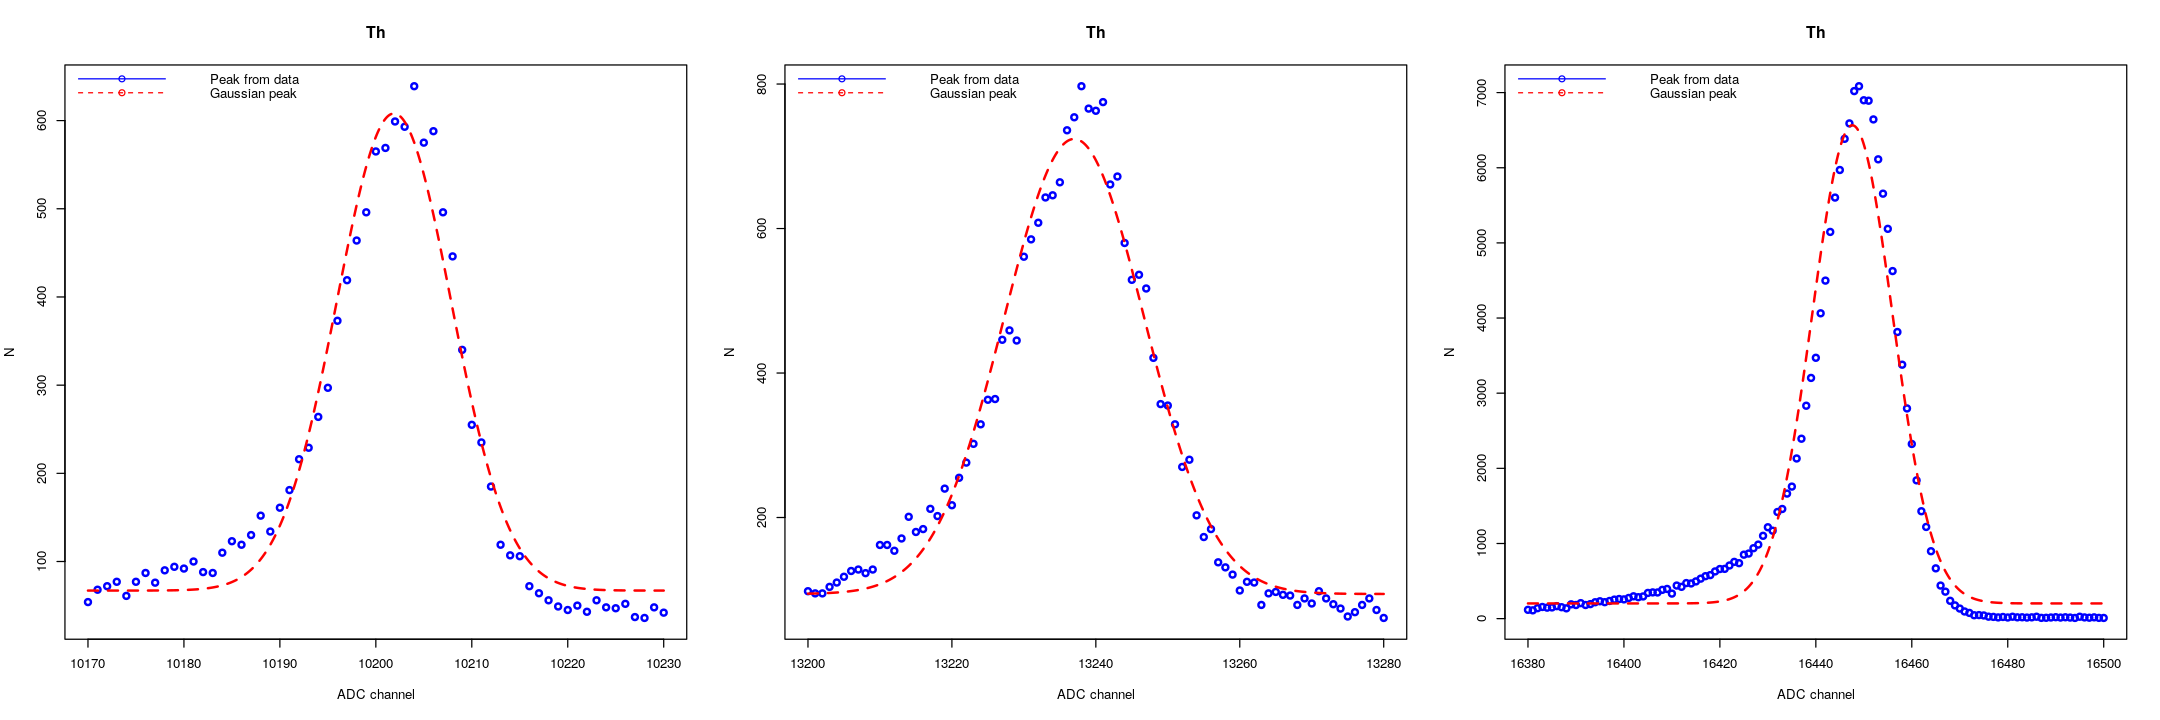

In [8]:
par(mfrow=c(1,3))
options(repr.plot.width = 18, repr.plot.height = 6) 
sigma.fit <- c()
mu.fit <- c()
stat.frame <- data.frame()
sigma_err <- c()

for (i in 1:length(peaks)){
    inf <- peaks_low[i]
    sup <- peaks_high[i]
    
    x <- adc[inf:sup]
    N <- counts[inf:sup]


    p <- c(amplitude[i],offset[i],peaks[i],2)

    inits = list(   "mu" = peaks[i],  
                    "logsigma" = log(1),
                    "A" = amplitude[i],
                    "B" = offset[i])
    data = list(N = N,X = x) 
    
    chain <- JAGS.fit(data,inits,nit = 1e4,thin = 20,burnin = 1e3,title='Th')
    #print(summary(chain)[[1]])
    sigma.fit <- append(sigma.fit, summary(chain)$statistics[4,1])
    
    mu.fit <- append(mu.fit, summary(chain)$statistics[3,1])
    
    sigma_err <- append(sigma_err, summary(chain)$statistics[4,2])
    
    stat.frame <- rbind(stat.frame,data.frame(summary(chain)[[1]]))

}    

In [9]:
stat.frame[,'SD']<-round(stat.frame[,'SD'],3)
options(digits=4, scipen=999)
stat.frame[1:20,]
#options(digits=3)
stat.frame[21:40,]
#options(digits=3)
stat.frame[41:60,]


Mean       SD      Naive.SE  Time.series.SE
A      136606.445 188.256 8.4190726 8.9825875     
B        4633.614  21.289 0.9520698 0.9520698     
mu       1503.212   0.003 0.0001326 0.0001326     
sigma       2.535   0.003 0.0001158 0.0001171     
A1       8065.798  49.028 2.1925798 2.0008944     
B1        824.455   7.506 0.3356944 0.3356944     
mu1      1890.178   0.015 0.0006583 0.0005995     
sigma1      2.780   0.014 0.0006230 0.0006230     
A2      11061.502  45.547 2.0369397 2.1658969     
B2        580.618   5.739 0.2566427 0.2829582     
mu2      3216.315   0.013 0.0005860 0.0007208     
sigma2      3.778   0.013 0.0005937 0.0005937     
A3      35603.290  82.183 3.6753415 3.6753415     
B3        808.528   7.128 0.3187609 0.3187609     
mu3      3672.346   0.007 0.0003099 0.0003099     
sigma3      3.722   0.007 0.0002924 0.0002924     
A4       6170.068  31.652 1.4155331 1.2827361     
B4        206.643   3.859 0.1725684 0.1725684     
mu4      4579.372   0.021 0.0009236 0.0009236     
sigma4      4.154   0.017 0.0007468 0.0007468

Mean     SD     Naive.SE Time.series.SE
A5      540.515 10.184 0.455427 0.491155      
B5       73.370  2.152 0.096235 0.096235      
mu5    4806.453  0.074 0.003305 0.003305      
sigma5    4.293  0.077 0.003436 0.003676      
A6      916.165 12.691 0.567567 0.567567      
B6       78.129  1.674 0.074873 0.074873      
mu6    4945.702  0.054 0.002408 0.002341      
sigma6    4.245  0.049 0.002185 0.002185      
A7     3418.059 22.922 1.025113 1.232720      
B7      108.353  1.905 0.085173 0.085173      
mu7    5417.937  0.026 0.001158 0.001158      
sigma7    4.620  0.025 0.001097 0.001018      
A8      263.569  7.168 0.320542 0.320542      
B8       51.763  1.498 0.066981 0.066981      
mu8    5625.115  0.125 0.005573 0.005573      
sigma8    4.504  0.122 0.005462 0.004823      
A9      309.564  7.508 0.335750 0.335750      
B9       52.709  1.458 0.065218 0.065218      
mu9    6791.556  0.103 0.004624 0.004624      
sigma9    4.701  0.105 0.004676 0.004676

Mean      SD     Naive.SE Time.series.SE
A10       133.439  4.796 0.214467 0.214467      
B10        40.516  0.919 0.041087 0.041087      
mu10     9523.094  0.214 0.009551 0.009551      
sigma10     6.062  0.226 0.010102 0.010102      
A11       453.803  7.719 0.345203 0.304504      
B11        46.341  1.457 0.065180 0.065180      
mu11    10025.999  0.085 0.003812 0.003812      
sigma11     5.234  0.080 0.003570 0.003570      
A12       541.032  8.465 0.378546 0.472802      
B12        67.034  1.643 0.073494 0.073494      
mu12    10201.889  0.085 0.003812 0.003812      
sigma12     5.954  0.087 0.003878 0.003878      
A13       629.828  7.193 0.321682 0.321682      
B13        94.170  2.060 0.092133 0.092133      
mu13    13236.989  0.107 0.004800 0.004800      
sigma13     9.740  0.116 0.005198 0.005198      
A14      6362.377 23.372 1.045224 1.045224      
B14       202.305  1.878 0.083976 0.076638      
mu14    16447.615  0.027 0.001219 0.001219      
sigma14     8.345  0.023 0.001026 0.001026

# Energy calibration  <a name="p2"></a>
Calibrating the detector to relate $E_{\gamma}$ with the relative $ADC$ channels

In [10]:
#mu
energyth <- c(238.632, 300.089, 510.74, 583.187, 727.330, 763.45, 785.37, 860.53, 893.408,  1078.63,  
          1512.70,  1592.511,  1620.738,  2103.511,  2614.511)

df<- data.frame(Energy=energyth, x0=mu.fit)
rownames(df) <- c('Th1','Th2','Th3','Th4','Th5','Th6','Th7','Th8','Th9','Th10','Th11','Th12','Th13','Th14','Th15')#
df

Energy x0   
Th1   238.6  1503
Th2   300.1  1890
Th3   510.7  3216
Th4   583.2  3672
Th5   727.3  4579
Th6   763.5  4806
Th7   785.4  4946
Th8   860.5  5418
Th9   893.4  5625
Th10 1078.6  6792
Th11 1512.7  9523
Th12 1592.5 10026
Th13 1620.7 10202
Th14 2103.5 13237
Th15 2614.5 16448

## Method 1: linear regression
Normal linear regression using the standard  *lm* from R


In [11]:
# The relation between ADC and Energy(keV) is considered to be linear of the form y=mx+c.
# lm() in R is a good tool to model them.
regression <- lm(formula =   df$x0 ~ df$Energy)
regression

# Extracting coefficients
m <- regression$coefficients[2]
q <- regression$coefficients[1]

summary(regression)

# changing adc channel axis to -->> to kev
# Energy is now simply obtained using the relation y=mx+c
a <- 1/m
b <- -q/m
cat(paste('a:',round(a,2),'\n'))
cat(paste('b:',round(b,2),'\n'))


Call:
lm(formula = df$x0 ~ df$Energy)

Coefficients:
(Intercept)    df$Energy  
       4.02         6.29  



Call:
lm(formula = df$x0 ~ df$Energy)

Residuals:
   Min     1Q Median     3Q    Max 
-4.542 -0.687 -0.349  1.250  3.342 

Coefficients:
            Estimate Std. Error t value            Pr(>|t|)    
(Intercept) 4.018105   1.014500    3.96              0.0016 ** 
df$Energy   6.291096   0.000804 7826.00 <0.0000000000000002 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 2.04 on 13 degrees of freedom
Multiple R-squared:     1,	Adjusted R-squared:     1 
F-statistic: 6.12e+07 on 1 and 13 DF,  p-value: <0.0000000000000002


a: 0.16 
b: -0.64 


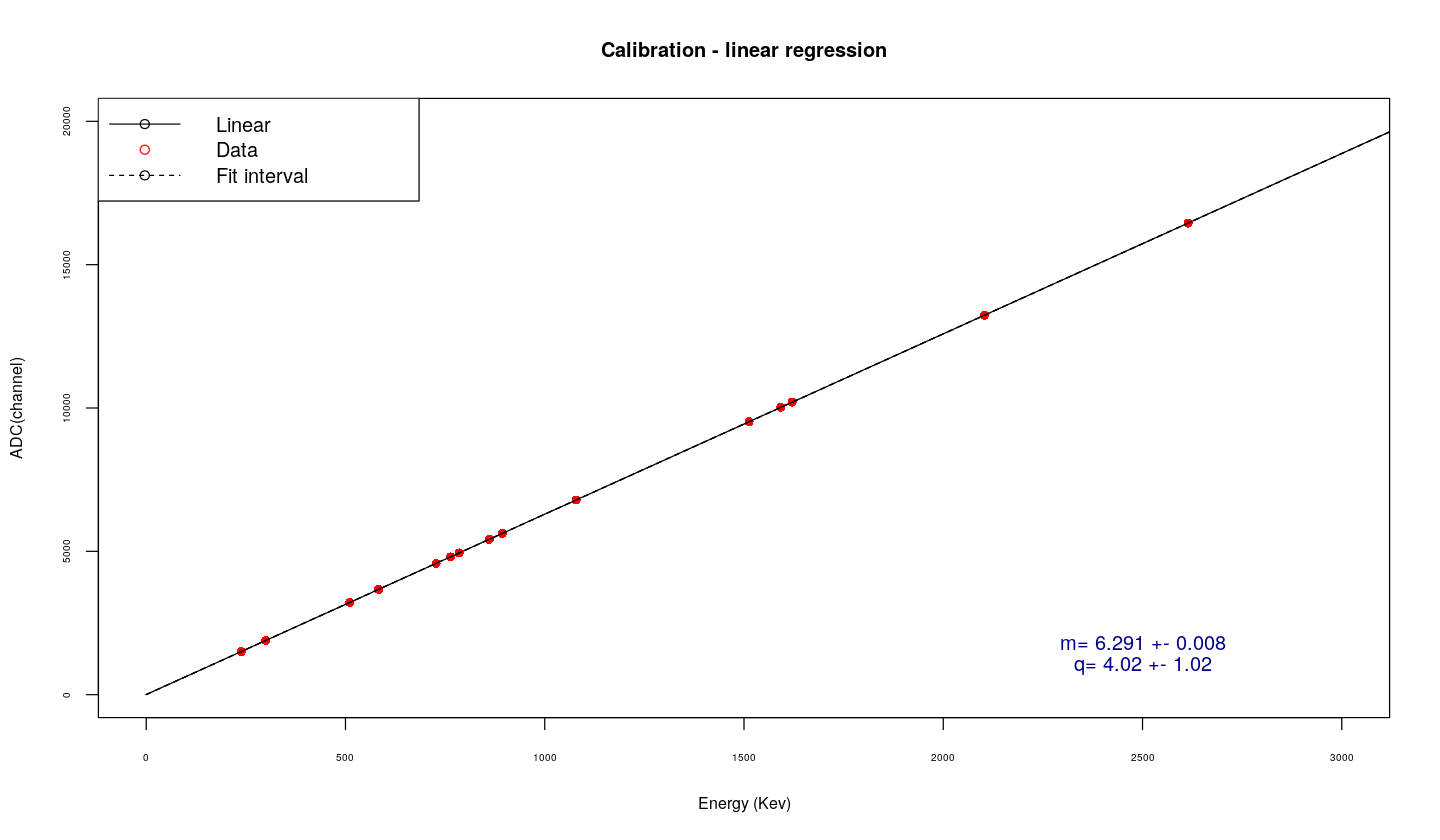

In [12]:
options(repr.plot.width=12, repr.plot.height=7)
plot(df$Energy, df$x0, col="red", pch=16, cex=1, xlab="Energy (Kev)",
     ylab="ADC(channel)",ylim=c(0,20000),xlim=c(0,3000), main='Calibration - linear regression',
     cex.main=1 ,yaxt="n",xaxt="n",cex.lab=0.8)
text(2500,1800,paste('m=',round(m,3),'+-',0.008),col='darkblue')
text(2500,1000,paste('q=',round(q,2),'+-',1.02),col='darkblue')
axis(2,cex.axis=0.5)
axis(1,cex.axis=0.5)
x <- seq(0,20000,1)
y1 <- (m-0.0008)*x + q-1.015
y <- m*x +q
y2 <- (m+0.0008)*x +q+1.015
lines(x,y, lty=1)
lines(x,y1, lty=2)
lines(x,y2, lty=2)

legend('topleft', legend=c('Linear','Data','Fit interval'),
       col=c('black','red','black'), pch=c(NULL,1,NULL), lty=c(1,0,2))

In [13]:
# function to plot the results with line
emission.lines <- function(vec){
    nuclides <- c('e1','e2','e3','e4','e5','e6','e7','e8','e9','e10','e11','e12','e13','e14','e15')
    i=0
    for (line in vec){
        i=i+1
        abline(v=line, col="blue", lty=2, lwd=1)
        text(line-50,2,paste(nuclides[i]," ",round(line,2)),srt=90,cex=1)      
    }
}

lines.only <- function(vec){
    nuclides <- c('e1','e2','e3','e4','e5','e6','e7','e8','e9','e10','e11','e12','e13','e14','e15')
    i=0
    for (line in vec){
        i=i+1
        abline(v=line, col="blue", lty=2, lwd=1)
    }
}

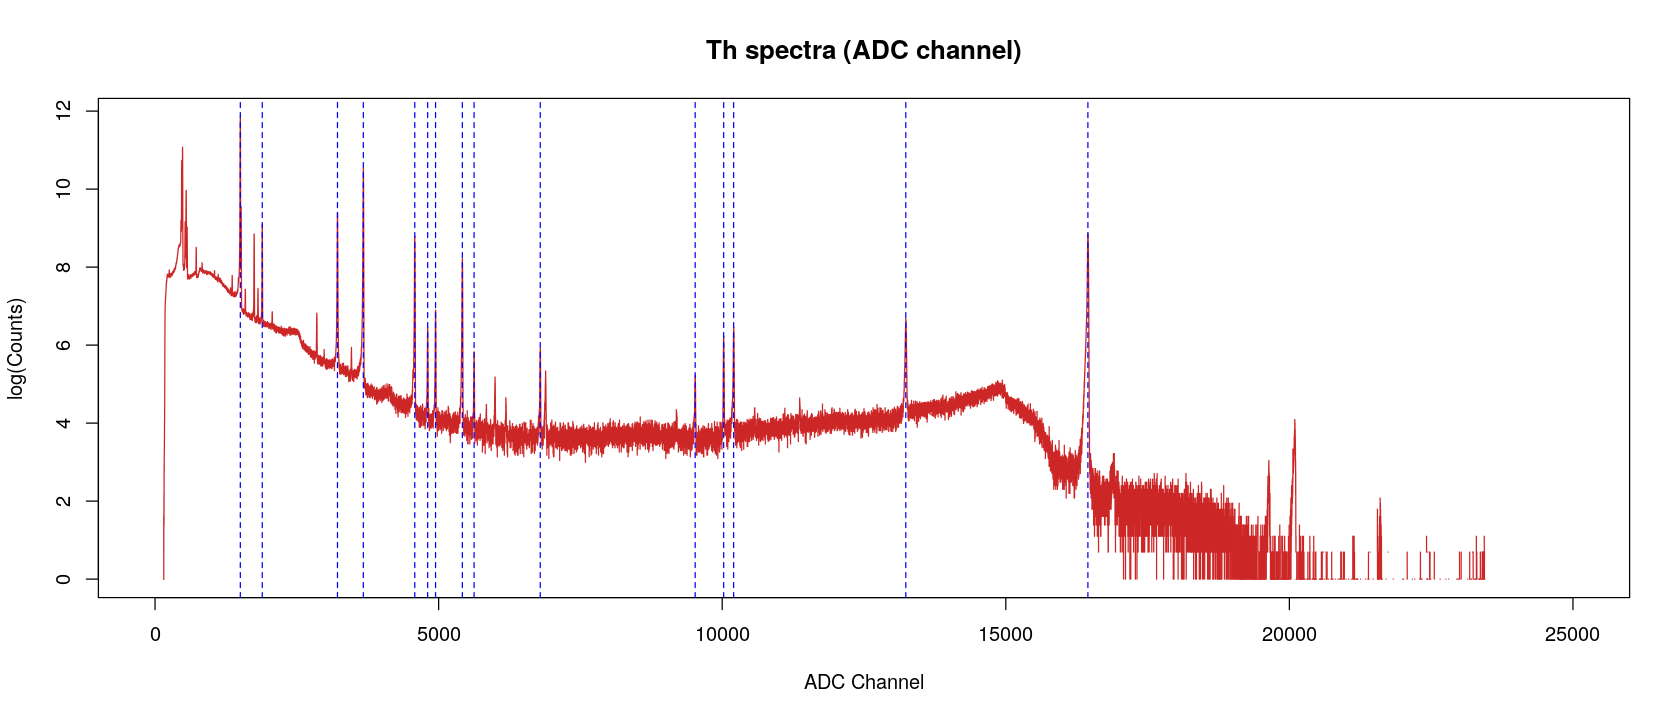

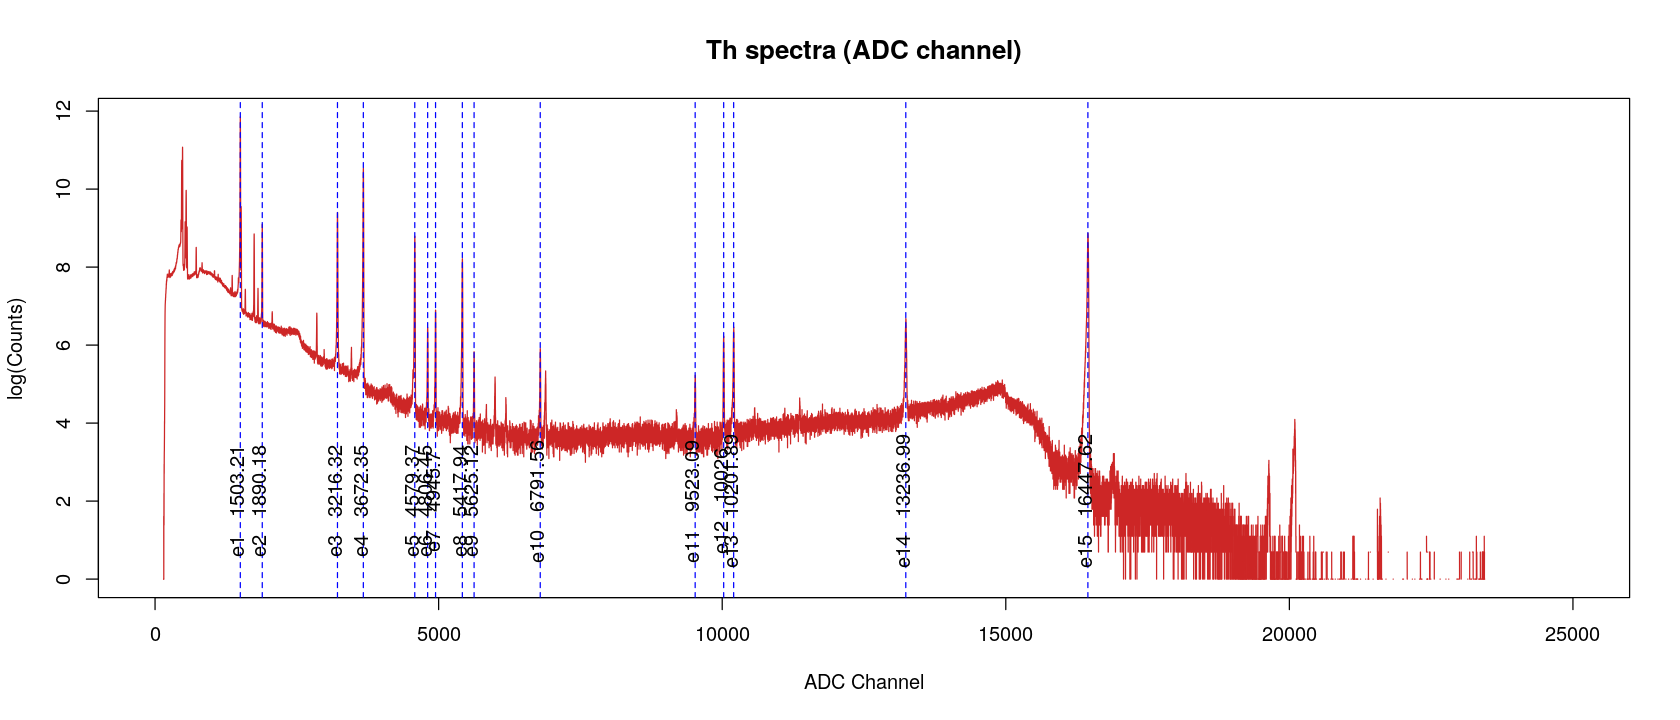

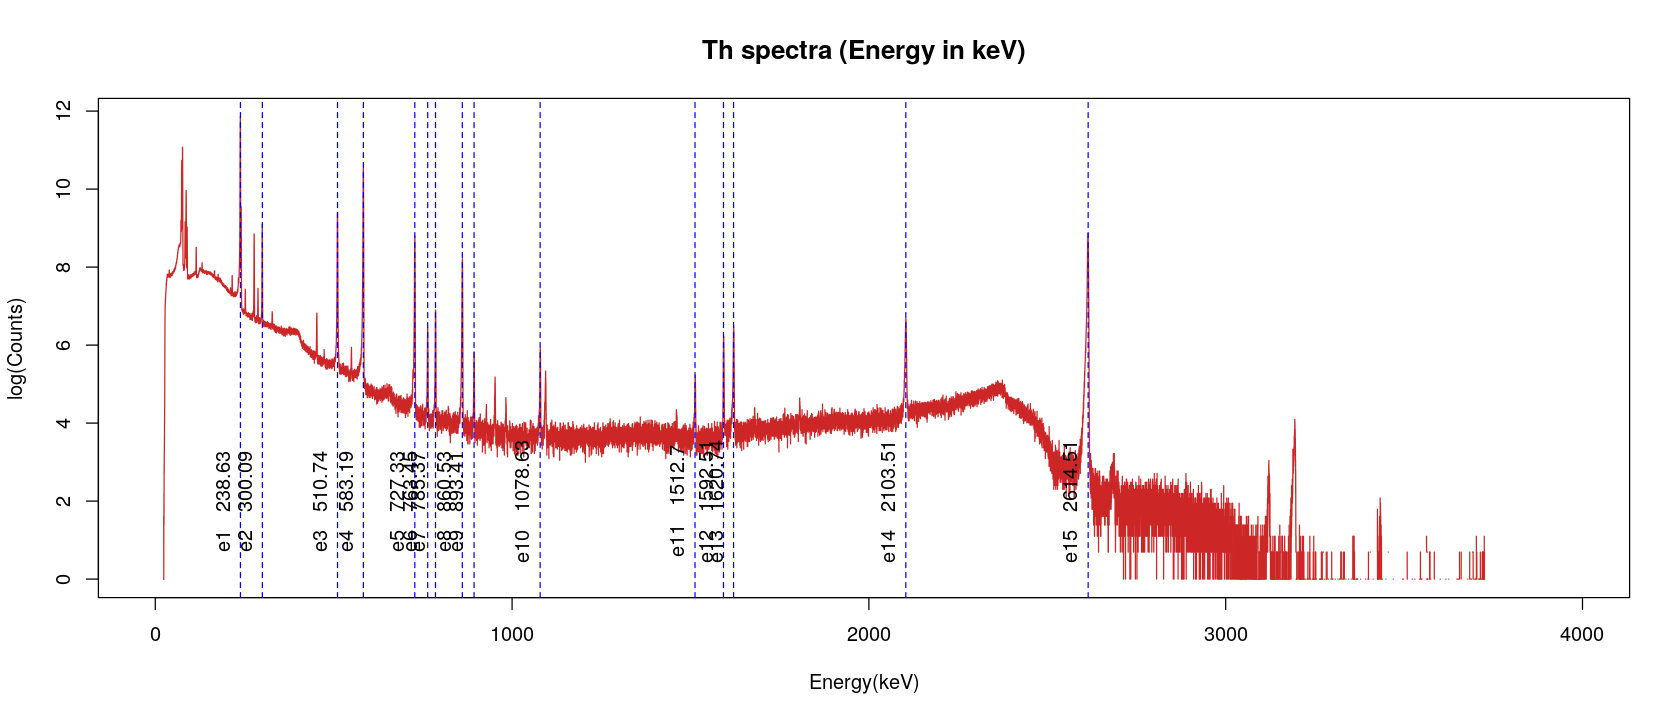

In [14]:
# log plots comparison, the one with x axis as ADC channel numbers and the other with x axis as Energy(keV)
data <- read.delim(file = 'IC48A_Th.txt')
colnames(data) <- c("adc", "counts")
data$x <- data$adc
data$y <-  data$counts
energy <- a*data$x + b


options(repr.plot.width=14, repr.plot.height=6)

plot(data$x, log(data$y),col='firebrick3',type='l',xlab="ADC Channel",ylab="log(Counts)",
     main="Th spectra (ADC channel)",cex.main=1.3,cex.lab=1,yaxt="n",xaxt="n")
axis(2,cex.axis=1)
axis(1,cex.axis=1)
lines.only(df$x0)


plot(data$x, log(data$y),col='firebrick3',type='l',xlab="ADC Channel",ylab="log(Counts)",
     main="Th spectra (ADC channel)",cex.main=1.3,cex.lab=1,yaxt="n",xaxt="n")
axis(2,cex.axis=1)
axis(1,cex.axis=1)
emission.lines(df$x0)


plot(energy, log(data$y),col='firebrick3',type='l',xlab="Energy(keV)",ylab="log(Counts)",
     main="Th spectra (Energy in keV)",cex.main=1.3,cex.lab=1,yaxt="n",xaxt="n")
axis(2,cex.axis=1)
axis(1,cex.axis=1)
emission.lines(df$Energy)

## Method 2: JAGS

Linear regression using the stat. framework *rjags* to infere the parameters and finding the $95\%$ confidence interval

In [15]:
data <- NULL
data$Y <- df$x0
data$X <- df$Energy
data$sigma <- sigma.fit
data

$Y
 [1]  1503  1890  3216  3672  4579  4806  4946  5418  5625  6792  9523 10026
[13] 10202 13237 16448

$X
 [1]  238.6  300.1  510.7  583.2  727.3  763.5  785.4  860.5  893.4 1078.6
[11] 1512.7 1592.5 1620.7 2103.5 2614.5

$sigma
 [1] 2.535 2.780 3.778 3.722 4.154 4.293 4.245 4.620 4.504 4.701 6.062 5.234
[13] 5.954 9.740 8.345

In [16]:
cat("model {

    # data likelihood
    for (i in 1:length(X)){
        Y[i] ~ dnorm(mu[i],1/(sigma[i]));
        mu[i] <- q + m*X[i];
    }

    #priors
    m <- tan(alpha);
    alpha ~ dunif(0,2)
    
    q ~ dunif(-100,100);
    a <- (1/m);
    b <- (-q/m);


    #predictions
    x_in <- 1200
    x_out <- 3200
    y_1 <- q + m*x_in;
    y_2 <- q + m*x_out;

}", file='Th_method2.bug')


init <- NULL
init$alpha <- pi/4

In [17]:
jm <- jags.model(file='Th_method2.bug',data, init=init)
update(jm,4000)
chain <- coda.samples(jm, c('a','b','y_1','y_2','m','q'), n.iter=2e5, thin=200)
print(summary(chain))

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 15
   Unobserved stochastic nodes: 2
   Total graph size: 107

Initializing model


Iterations = 5200:205000
Thinning interval = 200 
Number of chains = 1 
Sample size per chain = 1000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

         Mean        SD    Naive SE Time-series SE
a       0.159 0.0000241 0.000000762    0.000000762
b      -0.478 0.1565836 0.004951608    0.004951608
m       6.292 0.0009543 0.000030179    0.000030179
q       3.010 0.9848573 0.031143924    0.031143924
y_1  7553.498 0.6392803 0.020215818    0.019215881
y_2 20137.645 2.3026296 0.072815541    0.072815541

2. Quantiles for each variable:

         2.5%       25%       50%       75%     97.5%
a       0.159     0.159     0.159     0.159     0.159
b      -0.783    -0.585    -0.478    -0.374    -0.162
m       6.290     6.291     6.292     

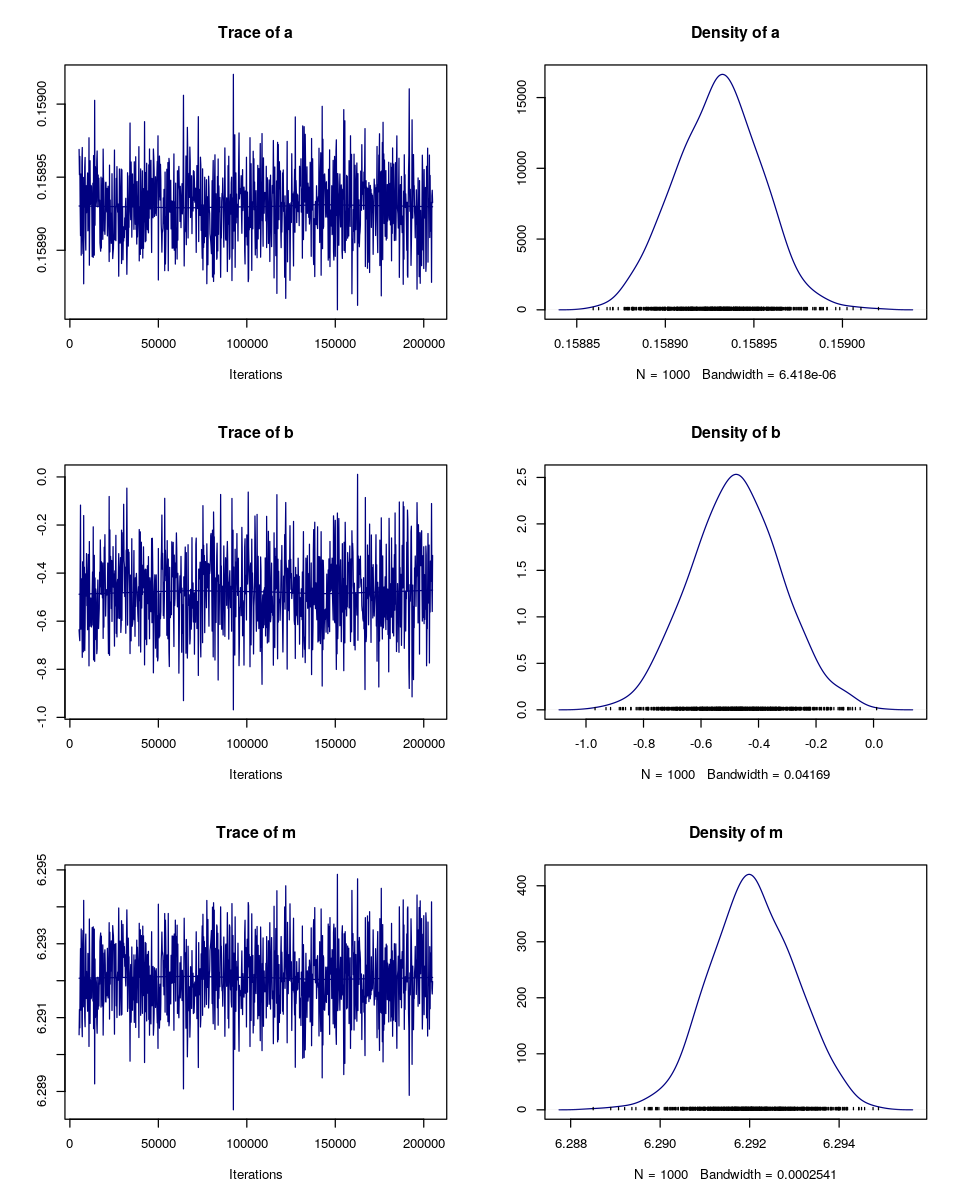

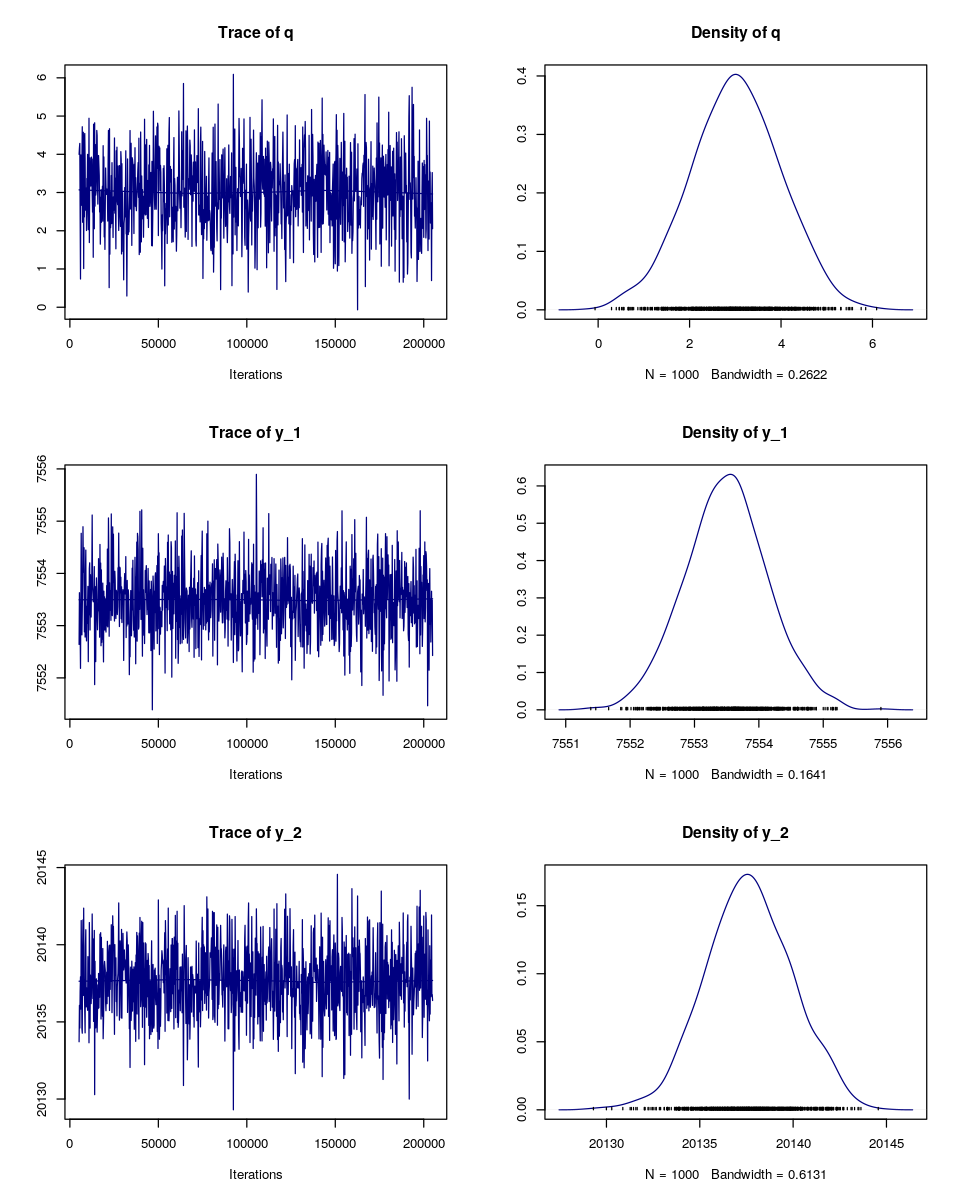

In [18]:
options(repr.plot.width=8, repr.plot.height=10)
plot(chain , col="navy")

In [19]:
sch <- summary(chain)
round(sch$statistics[,1:2],4)

Mean       SD    
a       0.1589 0.0000
b      -0.4783 0.1566
m       6.2921 0.0010
q       3.0096 0.9849
y_1  7553.4977 0.6393
y_2 20137.6445 2.3026

In [20]:
sch$quantiles

#so the 95% cred interval is 2.5%-97.5%
cat('95% cred. interval: \n')
cat('a: ',sch$quantiles[1,1],'-',sch$quantiles[1,5],'\n')
cat('b: ',sch$quantiles[2,1],'-',sch$quantiles[2,5],'\n')
cat('m: ',sch$quantiles[3,1],'-',sch$quantiles[3,5],'\n')
cat('q: ',sch$quantiles[4,1],'-',sch$quantiles[4,5],'\n')
cat('y_1: ',sch$quantiles[5,1],'-',sch$quantiles[5,5],'\n')
cat('y_2: ',sch$quantiles[6,1],'-',sch$quantiles[6,5])


2.5%       25%        50%        75%        97.5%     
a       0.1589     0.1589     0.1589     0.1589     0.1590
b      -0.7826    -0.5847    -0.4775    -0.3739    -0.1618
m       6.2902     6.2914     6.2920     6.2927     6.2940
q       1.0185     2.3530     3.0045     3.6791     4.9240
y_1  7552.2789  7553.0840  7553.5045  7553.9099  7554.7663
y_2 20133.2666 20136.1102 20137.6066 20139.2344 20142.0739

95% cred. interval: 
a:  0.1589 - 0.159 
b:  -0.7826 - -0.1618 
m:  6.29 - 6.294 
q:  1.019 - 4.924 
y_1:  7552 - 7555 
y_2:  20133 - 20142

In [21]:
a <- sch$statistics[1,1]
b <- sch$statistics[2,1]
m <- sch$statistics[3,1]
q <- sch$statistics[4,1]
y_1 <- sch$statistics[5,1]
y_2 <- sch$statistics[6,1]
a.jags <- a

In [22]:
data

$Y
 [1]  1503  1890  3216  3672  4579  4806  4946  5418  5625  6792  9523 10026
[13] 10202 13237 16448

$X
 [1]  238.6  300.1  510.7  583.2  727.3  763.5  785.4  860.5  893.4 1078.6
[11] 1512.7 1592.5 1620.7 2103.5 2614.5

$sigma
 [1] 2.535 2.780 3.778 3.722 4.154 4.293 4.245 4.620 4.504 4.701 6.062 5.234
[13] 5.954 9.740 8.345

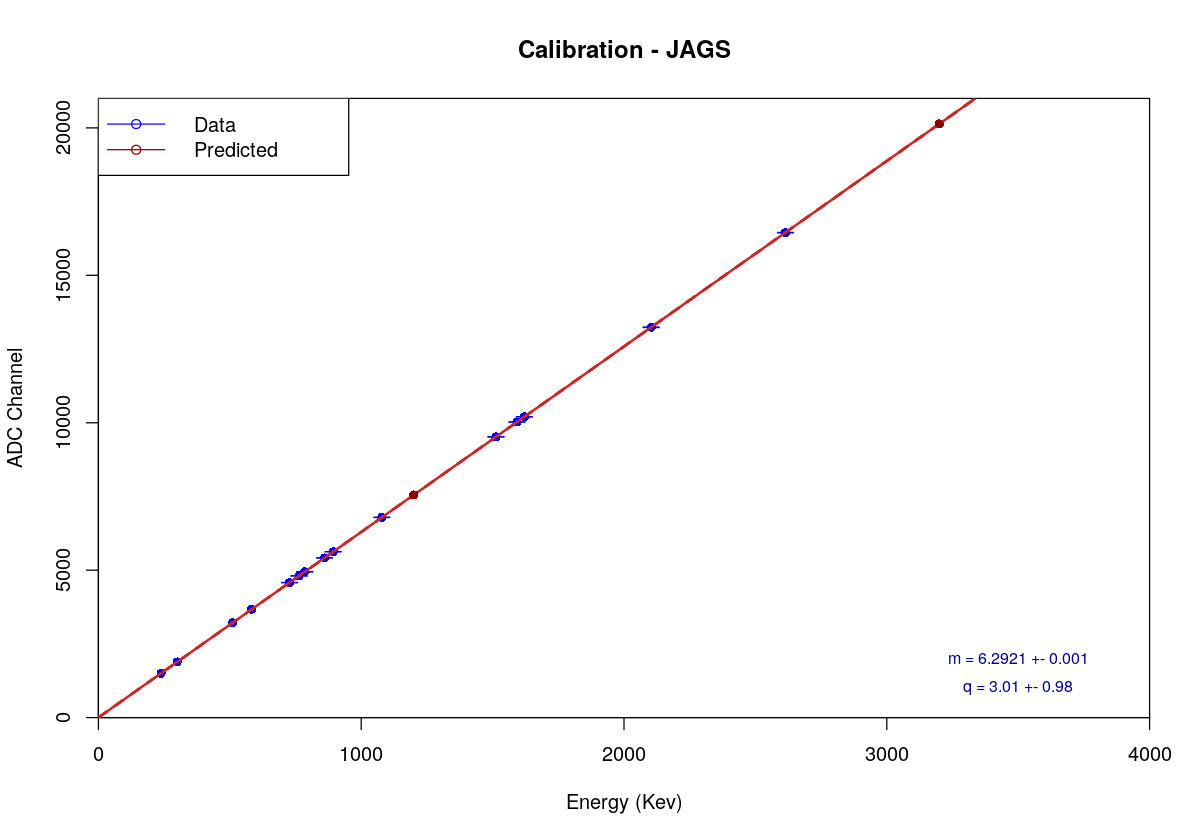

In [23]:
options(warn=-1)
options(repr.plot.width=10, repr.plot.height=7)
plotCI(data$X, data$Y,xlim=c(0,4000),ylim=c(0,21000), xaxs="i", yaxs="i",ylab="ADC Channel",xlab="Energy (Kev)",
       uiw=data$sigma, gap=0, col='blue',pch=16, main='Calibration - JAGS')
abline(a=q, b=m, lw=2, col='firebrick3')
abline(a=sch$quantiles[4,1], b=sch$quantiles[3,1], lw=2, col='firebrick3',lty=2)
abline(a=sch$quantiles[4,5], b=sch$quantiles[3,5], lw=2, col='firebrick3',lty=2)
plotCI(x_in <-1200 , y_1, uiw = sch$statistics[5,2], gap=0, add=TRUE ,lwd=2, col='darkred',xaxt="n",pch=16)
plotCI(x_out <-3200 , y_2, uiw = sch$statistics[6,2], gap=0, add=TRUE ,lwd=2, col='darkred', xaxt="n",pch=16)
#text(1200,9000,paste('ADC:',x_in), col='firebrick2',cex=1)
#text(2800,20000,paste('ADC:',x_out), col='firebrick2', cex=1)
text(3500,2000,paste('m =',round(m,4),'+-',round(sch$statistics[3,2],4)), col='darkblue',cex=0.8)
text(3500,1000,paste('q =',round(q,2),'+-',round(sch$statistics[4,2],2)), col='darkblue',cex=0.8)
legend('topleft', legend=c('Data','Predicted'), 
       col=c('blue','darkred'),lty=c(1,1), pch=c(1,NULL) )

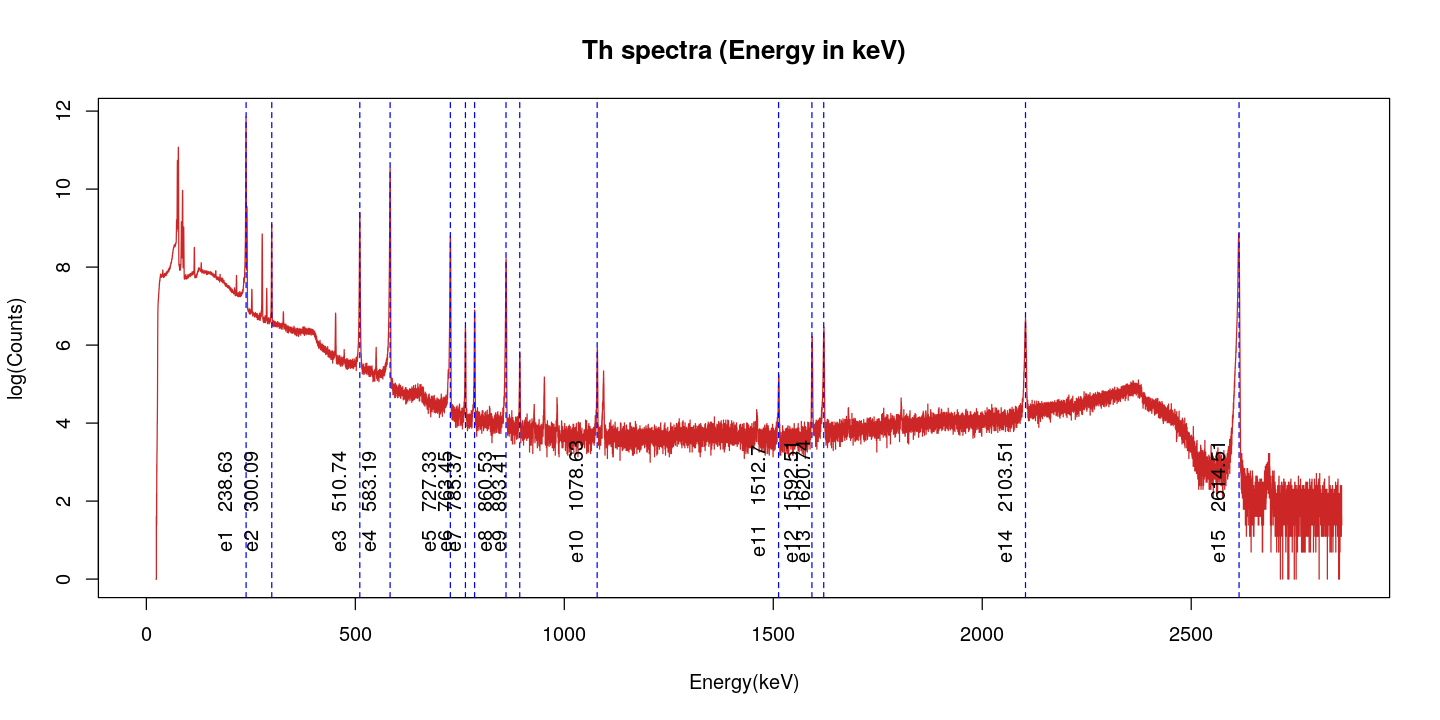

In [24]:
adc.df <- read.delim(file = 'IC48A_Th.txt')
colnames(adc.df) <- c("adc", "counts")

energy <- a*adc.df$adc + b
options(repr.plot.width=12, repr.plot.height=6)

plot(energy[0:18000], log(adc.df$counts)[0:18000],col='firebrick3',type='l',xlab="Energy(keV)",ylab="log(Counts)",
     main="Th spectra (Energy in keV)",cex.main=1.3,cex.lab=1,yaxt="n",xaxt="n")
axis(2,cex.axis=1)
axis(1,cex.axis=1)
emission.lines(df$Energy)

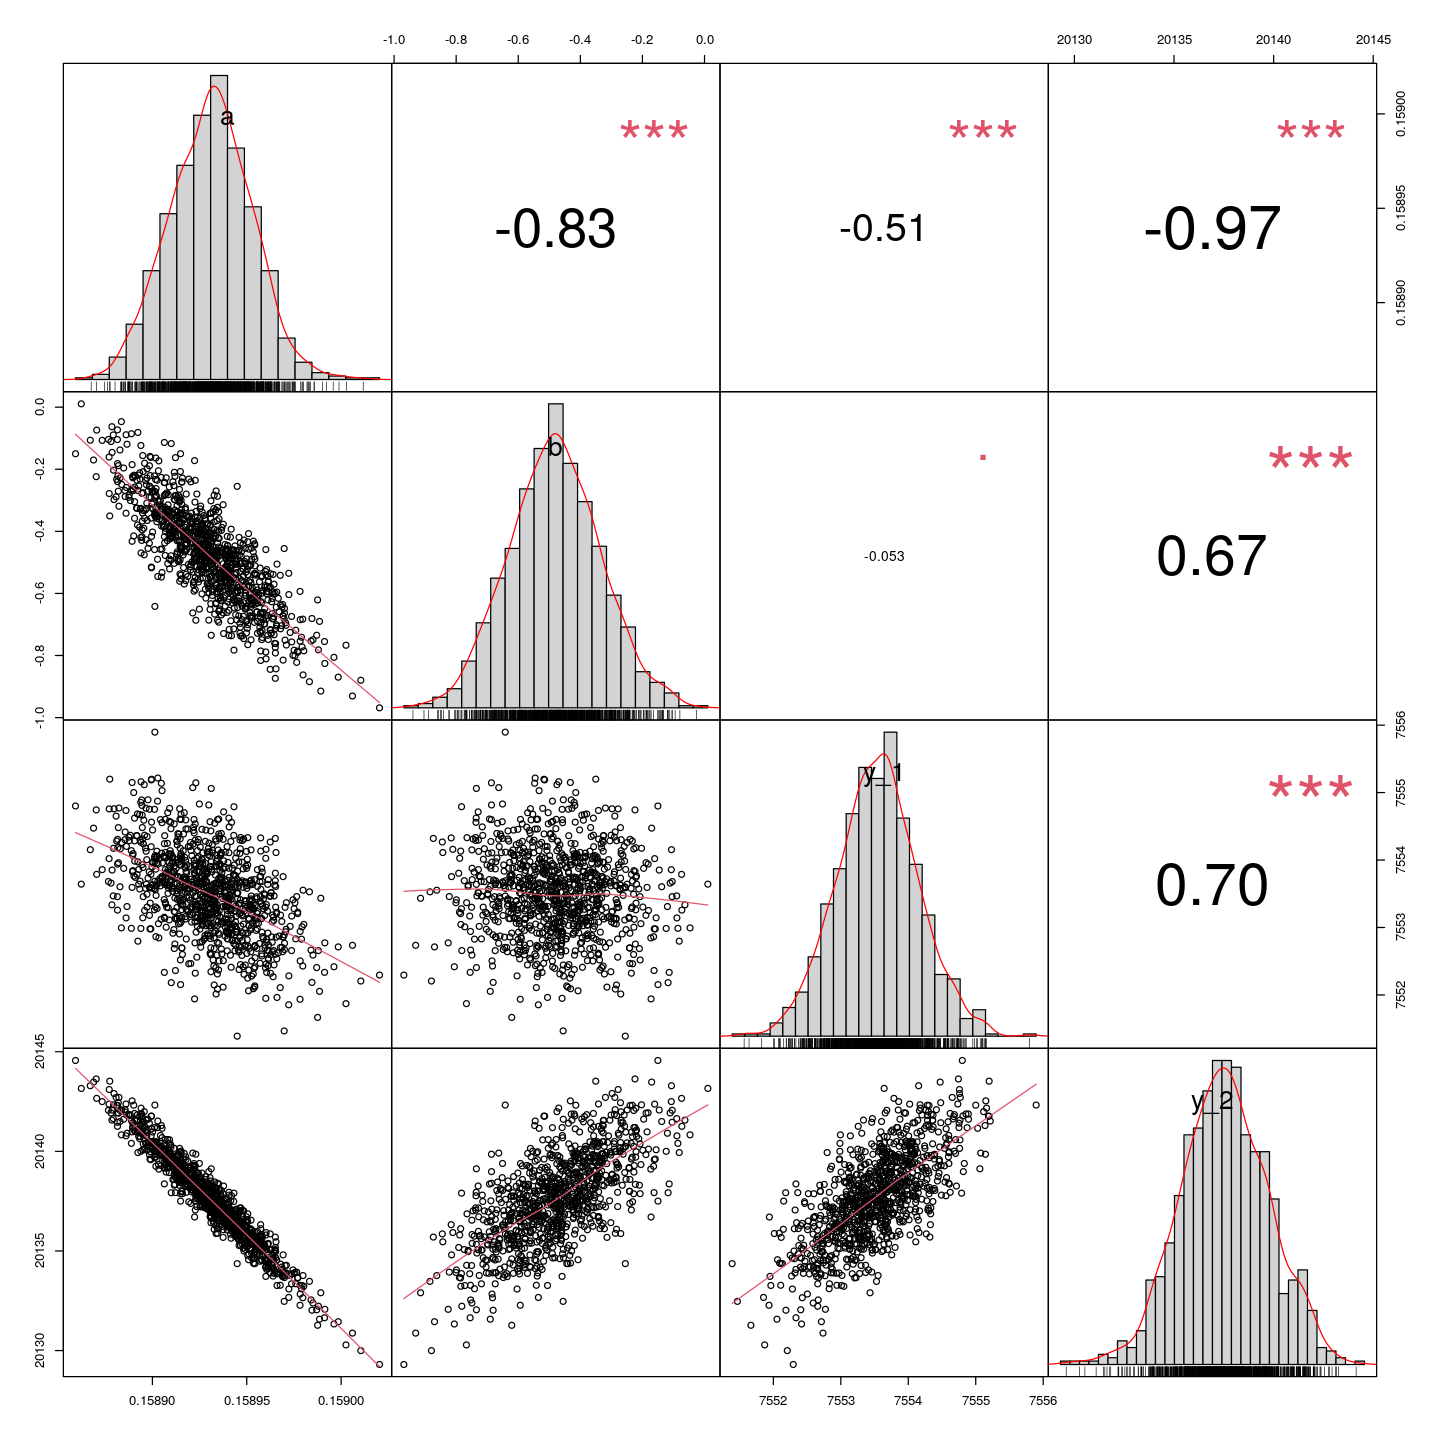

In [25]:
options(repr.plot.width=12, repr.plot.height=12)
chain.df <- as.data.frame(as.mcmc(chain))
chain.df <- chain.df[,c('a','b','y_1','y_2')]
chart.Correlation(chain.df, histogram = T, pch= 19)

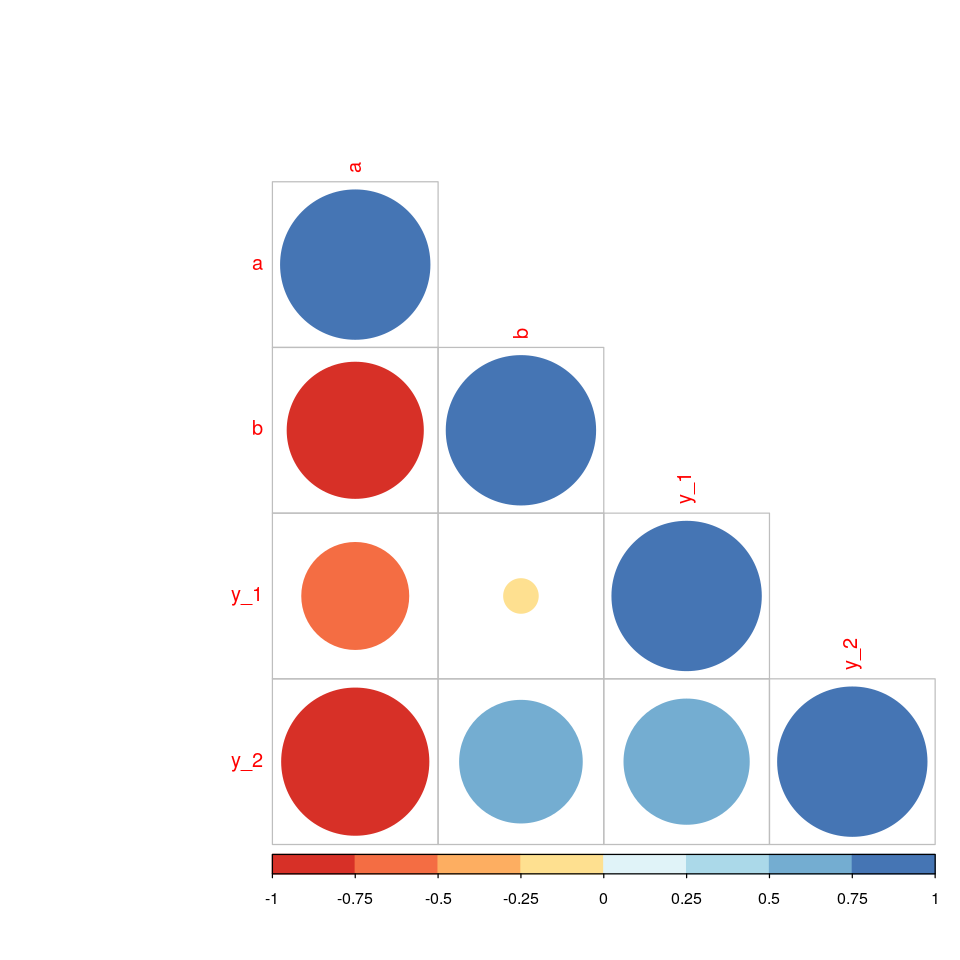

In [26]:
options(repr.plot.width=8, repr.plot.height=8)
M <-cor(chain.df)
corrplot(M, type="lower", order="hclust",
         col=brewer.pal(n=8, name="RdYlBu"))

## Study of the behavoiur of the energy resolution as a function of the photon energy: inference of the other parameters <a name="p3"></a>

Infering the parameters $w_{e}$ and $F$ (Fano factor) with JAGS (for a germanium detector $F \sim 0.13)$

In [27]:
#FWMH 
m <- 2.355
a <- a.jags
fwhm <- (sigma.fit*a*m)^2

# energy (keV)
th <- c(238.632, 300.089, 510.74, 583.187, 727.330, 763.45, 785.37, 860.53, 893.408,  1078.63,  
          1512.70,  1592.511,  1620.738,  2103.511,  2614.511)


df <- data.frame(E=th,FWHM=fwhm)
head(df)

options(repr.plot.width=6, repr.plot.height=6)


E     FWHM  
1 238.6 0.9002
2 300.1 1.0823
3 510.7 1.9999
4 583.2 1.9403
5 727.3 2.4176
6 763.5 2.5817

### Linear regression

In [28]:
# lm() in R for linear regression
regression <- lm(formula =   df$FWHM~ df$E )
regression

# Extracting coefficients
a <- regression$coefficients[2]
b <- regression$coefficients[1]


fwhm <- a * data$x+ b

summary(regression)


Call:
lm(formula = df$FWHM ~ df$E)

Coefficients:
(Intercept)         df$E  
   -0.77769      0.00439  



Call:
lm(formula = df$FWHM ~ df$E)

Residuals:
   Min     1Q Median     3Q    Max 
-2.374 -0.787 -0.009  0.347  4.836 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) -0.777687   0.806967   -0.96     0.35    
df$E         0.004389   0.000639    6.86 0.000011 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.62 on 13 degrees of freedom
Multiple R-squared:  0.784,	Adjusted R-squared:  0.767 
F-statistic: 47.1 on 1 and 13 DF,  p-value: 0.0000115


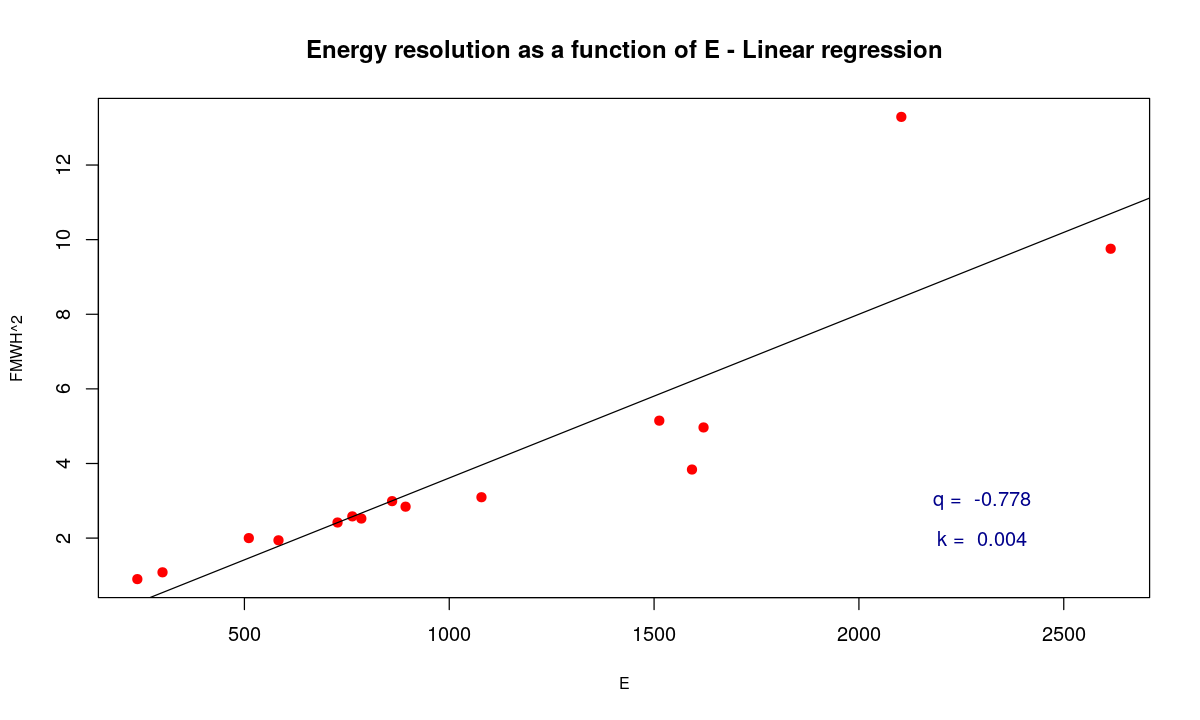

In [29]:
options(repr.plot.width = 10, repr.plot.height = 6) 
plot(df$E, df$FWHM, col="red", pch=20, cex=1.5, xlab="E",ylab='FMWH^2',cex.lab=.8,
    main="Energy resolution as a function of E - Linear regression")
x <- seq(0,8000,1)
y <- a*x +b
lines(x,y)
text(2300,2,paste('k = ',round(a,3)),col='darkblue',cex=1)
text(2300,3,paste('q = ',round(b,3)), col='darkblue',cex=1)

From the results of the linear regression we can only find the Fano factor, due to a negative value of q. The value is:

$$ F \simeq 0.24$$



### JAGS

In [30]:
cat("model {

    # data likelihood
    for (i in 1:length(Y)){
        Y[i] ~ dnorm(mu[i],1/sigma);
        mu[i] <- (w_e^2+(2.355^2)*0.003*X[i]*f)^0.5;
    }

    #priors
    w_e ~ dunif(-3,3);
    f ~ dunif(0,1);
    sigma <- exp(logsigma)
    logsigma ~ dunif(-10,10) 

}", file='model3fh.bug')

data <- NULL
data$X <- df$E
data$Y <- df$FWHM**0.5
data

init <- NULL

$X
 [1]  238.6  300.1  510.7  583.2  727.3  763.5  785.4  860.5  893.4 1078.6
[11] 1512.7 1592.5 1620.7 2103.5 2614.5

$Y
 [1] 0.9488 1.0403 1.4142 1.3929 1.5549 1.6068 1.5887 1.7293 1.6858 1.7594
[11] 2.2689 1.9590 2.2284 3.6457 3.1235

In [31]:
jm <- jags.model(file='model3fh.bug',data, init=init)
update(jm,4000)
chain <- coda.samples(jm, c('f','w_e','sigma'), n.iter=2e5, thin=200)
print(summary(chain))

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 15
   Unobserved stochastic nodes: 3
   Total graph size: 92

Initializing model


Iterations = 5200:205000
Thinning interval = 200 
Number of chains = 1 
Sample size per chain = 1000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

        Mean     SD Naive SE Time-series SE
f     0.2089 0.0210 0.000663       0.000746
sigma 0.0977 0.0435 0.001375       0.001375
w_e   0.0155 0.4029 0.012739       0.012025

2. Quantiles for each variable:

         2.5%     25%    50%   75% 97.5%
f      0.1668  0.1960 0.2095 0.222 0.248
sigma  0.0444  0.0684 0.0865 0.116 0.217
w_e   -0.7251 -0.2780 0.0186 0.290 0.794



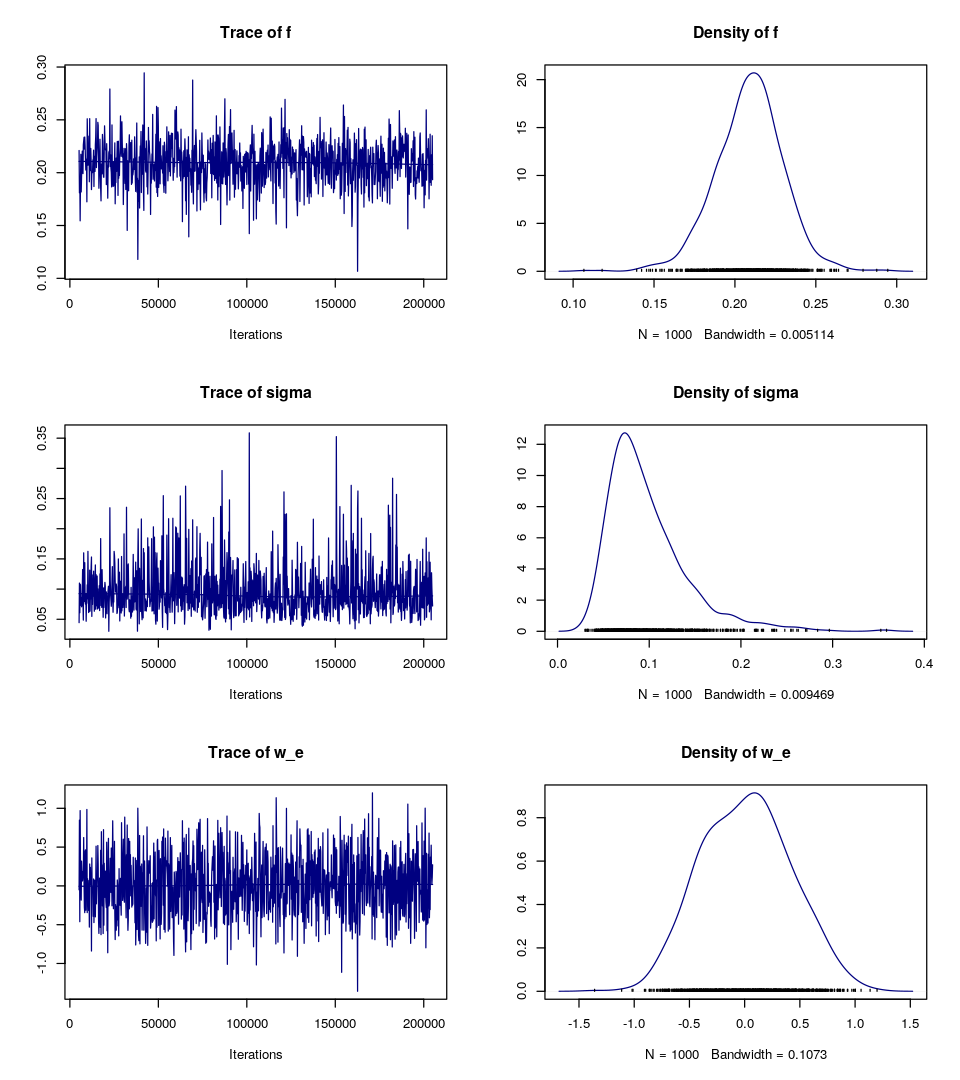

In [32]:
options(repr.plot.width=8, repr.plot.height=9)
plot(chain , col="navy")

In [33]:
sch <- summary(chain)
sch$statistics[,1:2]

sch$quantiles

#so the 95% cred interval is 2.5%-97.5%
cat('95% cred. interval: \n')
cat('f: ',sch$quantiles[1,1],'-',sch$quantiles[1,5],'\n')
cat('we: ',sch$quantiles[3,1],'-',sch$quantiles[3,5],'\n')
cat('sigma: ',sch$quantiles[2,1],'-',sch$quantiles[2,5],'\n')


Mean    SD     
f     0.20894 0.02097
sigma 0.09768 0.04349
w_e   0.01549 0.40286

2.5%     25%      50%     75%    97.5% 
f      0.16677  0.19596 0.20948 0.2217 0.2483
sigma  0.04439  0.06845 0.08652 0.1161 0.2166
w_e   -0.72512 -0.27798 0.01858 0.2901 0.7942

95% cred. interval: 
f:  0.1668 - 0.2483 
we:  -0.7251 - 0.7942 
sigma:  0.04439 - 0.2166 


In [34]:
ff <- sch$statistics[1,1]
sigma <- sch$statistics[2,1]
w_e <- sch$statistics[3,1]
ff.cred <- c(sch$quantiles[1,1],sch$quantiles[1,5])
w_e.cred <- c(sch$quantiles[3,1],sch$quantiles[3,5])

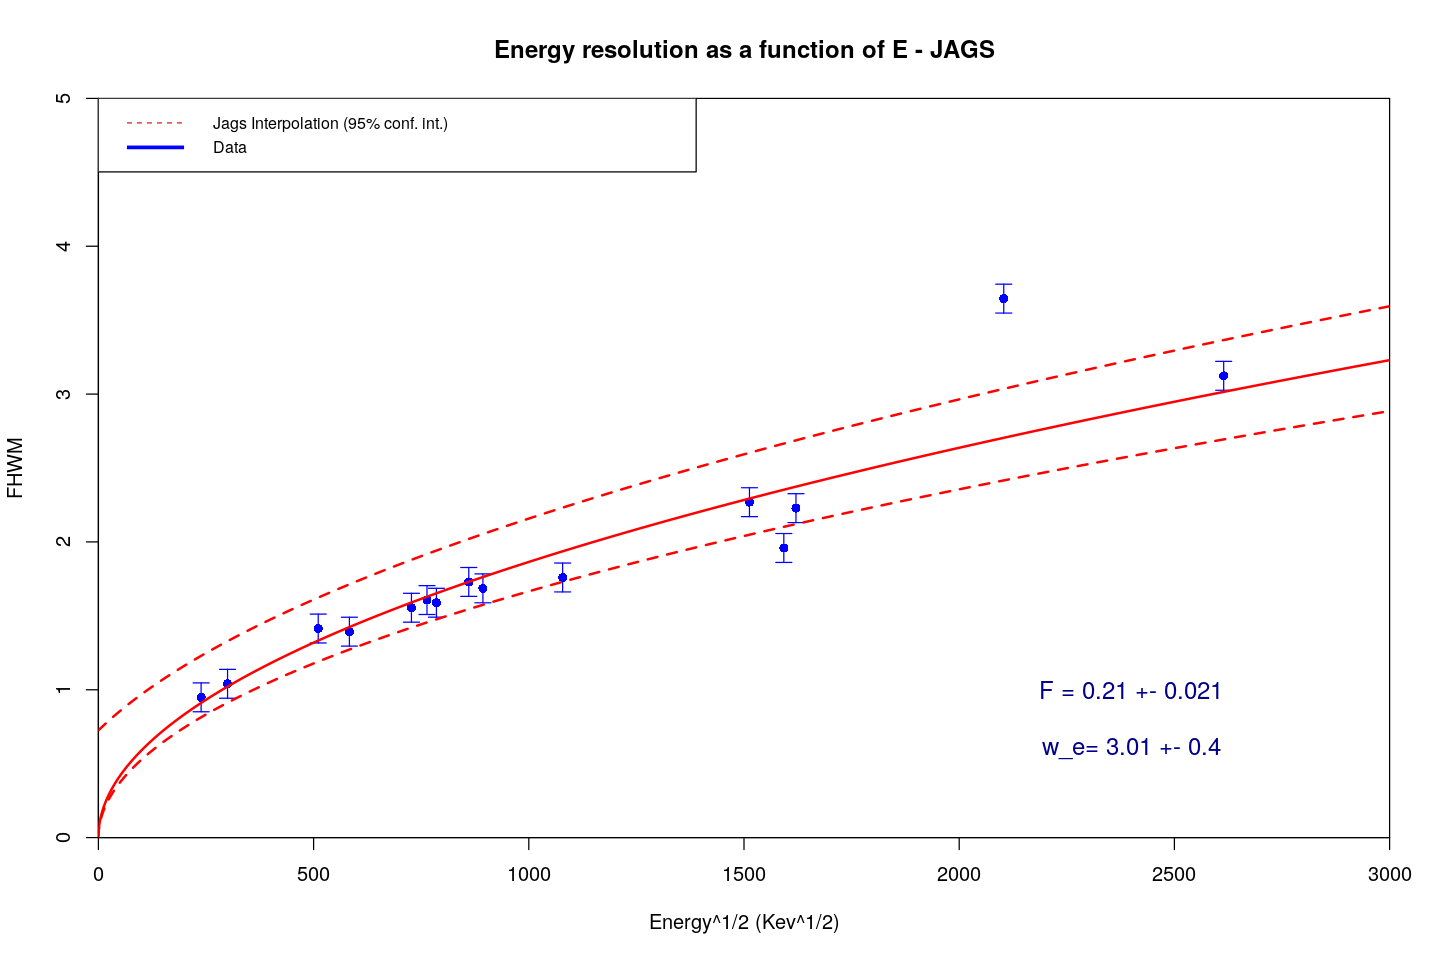

In [35]:
options(repr.plot.width=12, repr.plot.height=8)
plotCI(data$X, data$Y, xlim=c(0,3000), ylim=c(0,5), xaxs="i", yaxs="i",ylab="FHWM",xlab="Energy^1/2 (Kev^1/2)",
       main="Energy resolution as a function of E - JAGS",
       uiw=sigma, gap=0, col='blue',pch=16)

xx <- 0:3000
yy <- (w_e^2+(2.355^2)*0.003*xx*ff)^0.5
yy_up <- (w_e.cred[1]^2+(2.355^2)*0.003*xx*ff.cred[2])^0.5
yy_down <- ((2.355^2)*0.003*xx*ff.cred[1])^0.5

lines(xx,yy,'l',lwd=2,col='red')
lines(xx,yy_up,'l',lwd=2,col='red',lty=2)
lines(xx,yy_down,'l',lwd=2,col='red',lty=2)

text(2400,1,paste('F =',round(ff,2),'+-',round(sch$statistics[1,2],3)), col='darkblue',cex=1.2)
text(2400,0.6,paste('w_e=',round(q,2),'+-',round(sch$statistics[3,2],2)), col='darkblue',cex=1.2)
legend('topleft', legend=c('Jags Interpolation (95% conf. int.)','Data'), 
       col=c('firebrick3','blue'),lty=c(2,1,1),lwd=c(1,3,3), cex=0.8)




As we see the autocorrelation of the chain tends to zero always. This means that our choice of the burn-in does not impact at all the correlation of the data.

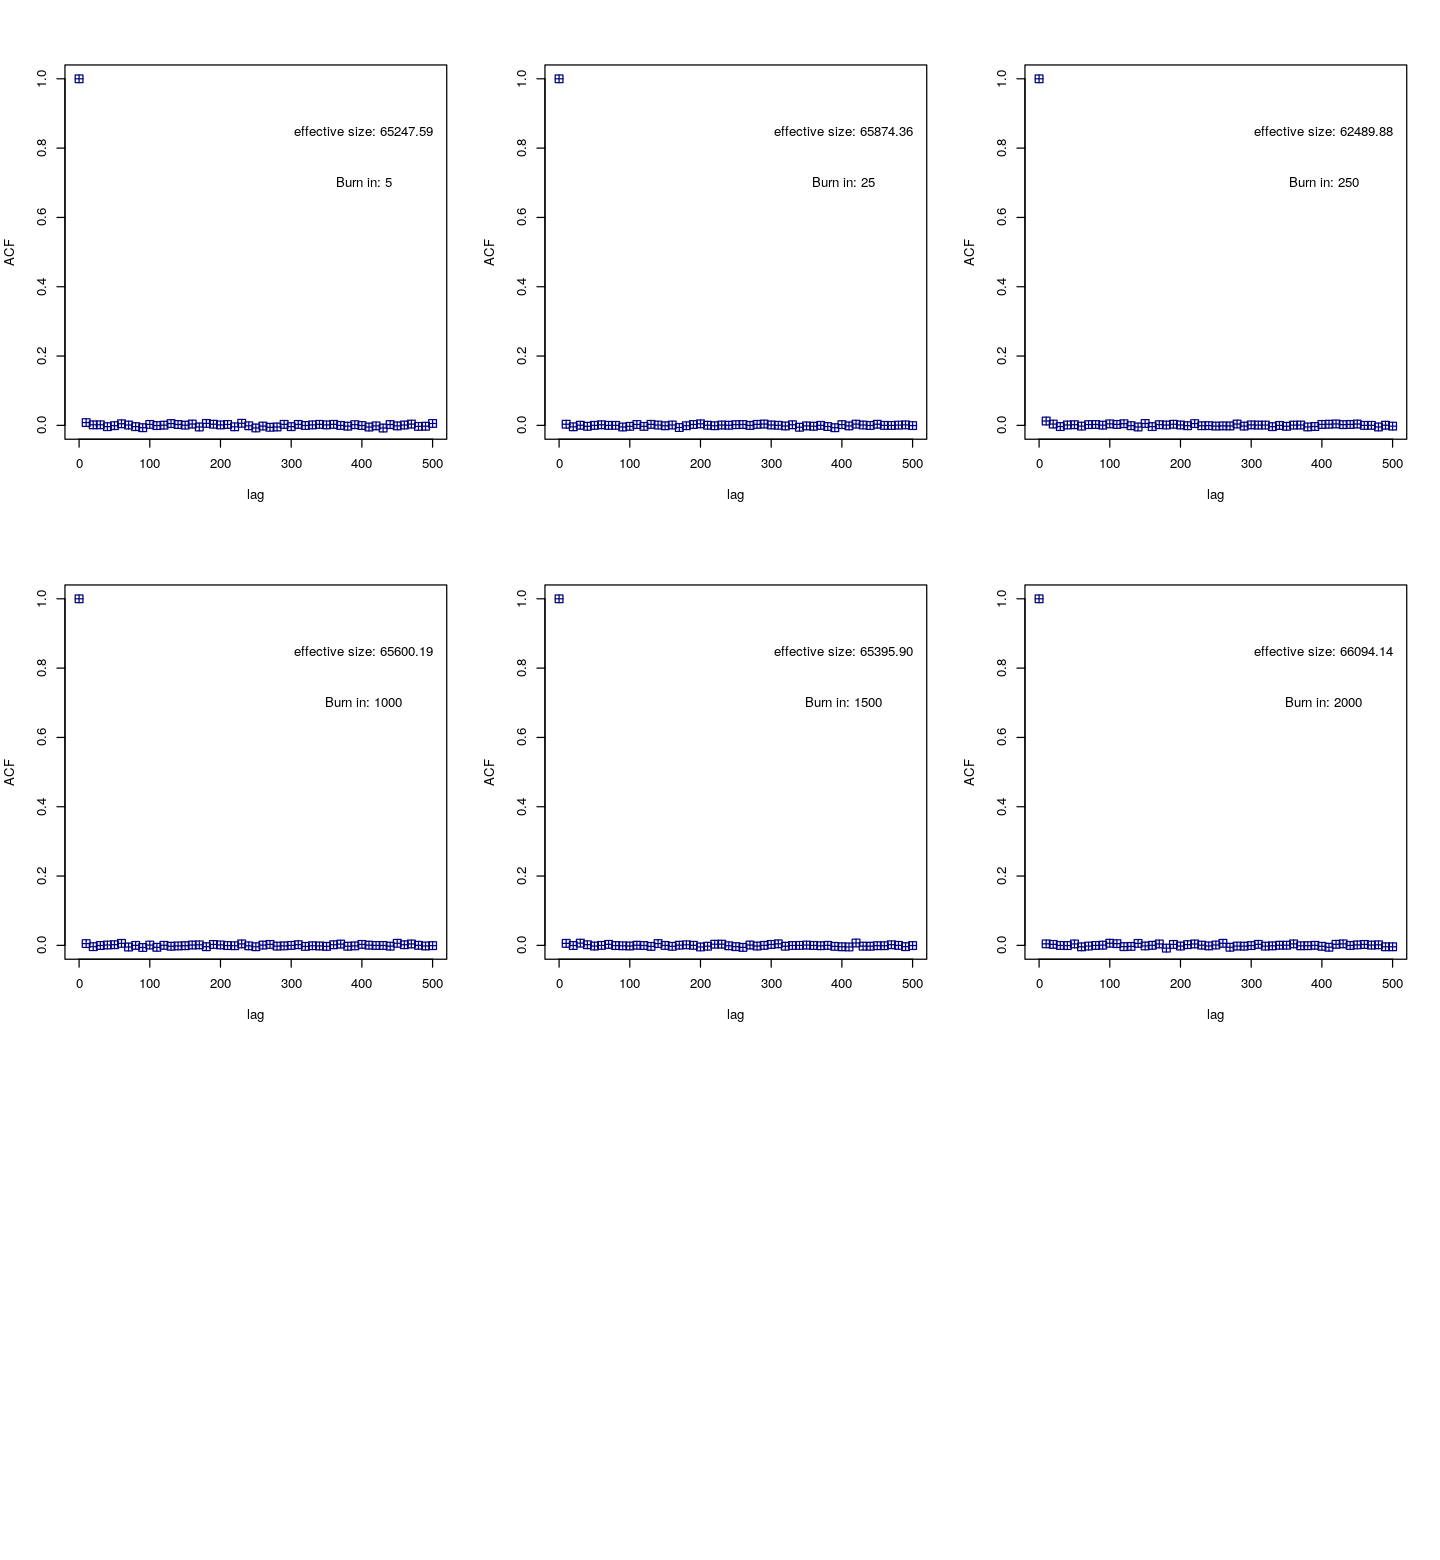

In [36]:
options(repr.plot.width=12, repr.plot.height=13)
par(mfrow=c(3,3))
burnin.vals <- c(5,25,250,1000,1500,2000)
for (burn in burnin.vals){
    update(jm , burn)
    chain <- coda.samples(jm , variable.names=c('f','sigma','we'), n.iter = 2e5, thin = 1)
    chain.df <- as.data.frame(as.mcmc(chain))
    my.lags = seq(0,500,10)
    # Here we need use as.mcmc(chain.df$b0) because
    y <- autocorr(as.mcmc(chain.df$f), lags=my.lags)
    plot(my.lags , y, ylim=c(0,1),pch=12, col='navy',
    xlab='lag', ylab='ACF', cex=1.3)
    text(400,0.85, sprintf (" effective size: %.2f", effectiveSize(as.mcmc(chain.df$f))))
    text(400,0.7, sprintf (" Burn in: %d", burn))
}